# <center> Guia 2 </center>
Alumno: Brusco Agustín

Docentes: Rodriguez Imazio Paola, Amette Estrada Julian

## Imports Generales
Ejecutar la siguiente celda para poder correr el código del Notebook.

In [1]:
import sys
import os
# Colab Set-Up
if ("google.colab" in sys.modules) and (os.getcwd() == '/content'):
    print(
        "Ejecutando en Google Colab\n"
        "Para correr el notebook se necesita clonar un repositorio con funciones "
        "auxiliares e instalar librerías."
    )
    if input(
        "¿Desea clonar el repositorio e instalar los paquetes necesarios?"
        "[y/n]:"
    ).lower() == "y":
        os.system("git clone https://github.com/agustinbrusco/Sistemas_Complejos.git")
        print(
            "Se clonó https://github.com/agustinbrusco/Sistemas_Complejos.git."
        )
        os.chdir("Sistemas_Complejos/guias/")
        %pip install findiff
        %pip install ipympl
    from google.colab import output
    output.enable_custom_widget_manager()

# Imports Generales
from typing import Callable
from tqdm.notebook import tqdm
import numpy as np
from numpy.typing import ArrayLike
from scipy.integrate import odeint, ode
import torch
import json
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"

from utils import (plot_3d_evolution, plot_colorline, plot_training_loss,
                   CustomFunctionMLP, get_model_info, save_model_info)

## **La ecuación de Burgers**





La ecuación de Burgers

\begin{equation}
    \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0.                          
\end{equation}

Forma parte de un grupo de ecuaciones no-lineales en derivadas parciales
"universales" que aparecen en muchos contextos.

En rigor, fue introducida en 1915 por Bateman [1], quien propuso una
solución de estado estacionario para el problema. Más
tarde, en 1948, el físico holandés J. M. Burgers, propuso
esta ecuación como modelo matemático de turbulencia [2,
3] y debido a su amplia contribución, la ecuación lleva su
nombre. A pesar de ser una versión simplificada de la ecuación de Navier Stokes,
se caracteriza por tener un término
dependiente del tiempo, un término de advección y un
término de difusión, con lo cual guarda la no-linealidad y las principales características de esta.
Se utiliza muchas veces como modelo de juguete para testear implementaciones numéricas de flujos turbulentos.

En su forma mas general (con el término de difusión) la ecuación es del tipo parabólica, mientras que en el caso ideal (invisido) es una ecuación hiperbólica. En ambos casos, resulta útil buscar leyes de conservación, de camino a las soluciones.

[1] Bateman, H., Some recent researches on the motion of
fluids, Monthy Wather Rev. 43, 163-170 (1915).

[2] Burgers, J. M., A mathematical model illustrating the
theory or turbulence, Advances in Applied Mechanics 1,
171-199 (1948).

[3] Burgers, J. M., Mathematical examples illustrating
relations occuring in the theory of turbulent fluid motion,
Trans. Roy. Neth. Acad. Sci. Amsterdam 1. 17, 1-53
(1939).

## **Ejercicio 1**


$\bf a)$ Mostrar que esta ecuación conserva el momento incluso para $\nu \neq 0$.

$\bf b)$ A partir de la ecuación de balance mostrá la conservación local de la energía. Bajo que condiciones se conserva la energía global?

$\bf c)$ Explica la aparición de "frentes" a partir de la ecuación para la evolución de los gradientes. (*Ayuda: esto puede hacerce derivando la ecuación de Burgers con respecto de x*)

$\bf d)$ Mediante la sustitución: $u(x,t) = -2\nu \partial_x\phi/\phi$ (transformación de Hopf) es posible hallar la solución exacta de (1). Escribí la ecuación. Que tipo de soluciones tiene? Describí la aparición de frentes en términos de estas soluciones.



---
**Resolución aqui**


---



### a)
Para observar la conservación del momento en la Ecuación de Burgers podemos reescribirla como:
$$\frac{\partial u}{\partial t} + \frac{\partial}{\partial x}\left(\frac{u^2}{2} - \nu \frac{\partial u}{\partial x}\right) = 0.$$
Luego, si integramos respecto de $x$ en el intervalo $[a,b]$ obtenemos:
$$\int\limits_a^b \frac{\partial u}{\partial t} \,\mathrm{d}x + \int\limits_a^b \frac{\partial}{\partial x}\left(\frac{u^2}{2} - \nu \frac{\partial u}{\partial x}\right) \,\mathrm{d}x = 0,$$
$$\Rightarrow \frac{\partial}{\partial t}\int\limits_a^b u \,\mathrm{d}x + \left[\frac{u^2}{2} - \nu \frac{\partial u}{\partial x}\right]_a^b = 0.$$
Tomando ahora que $u(a,t) = u(b,t)$ (condiciones de borde comptabiles con un flujo periódico o con extremos cerrados) se tiene que el segundo término se anula, obteniendo:
$$\frac{\partial}{\partial t}\int\limits_a^b u \,\mathrm{d}x = 0.$$
Luego puede sumarse el término $u \frac{\partial}{\partial x} \int_a^b u \, \mathrm{d}x$ a la ecuación sin alterarla (ya que $\int_a^b u \, \mathrm{d}x$ no depende de $x$), obteniendo la derivada convectiva de la integral:
$$\frac{\mathrm{d}}{\mathrm{d}t}\int\limits_a^b u \,\mathrm{d}x = 0,$$
siendo la integral en el lado izquierdo la cantidad de momento en el intervalo $[a,b]$. De esta manera, tenemos que el momento se conserva globalmente (en el recinto) en el tiempo.

### b)
Para mostrar la conservación de la energía multiplico la ecuación de Burgers por $u$ y reescribo la ecuación como:
$$
\begin{align*}
 u\frac{\partial u}{\partial t} + u^2\frac{\partial}{\partial x}u & = & \nu u \frac{\partial^2 u}{\partial x^2} \\
 \iff \frac{\partial}{\partial t}\!\left(\frac{u^2}{2}\right) + u\frac{\partial}{\partial x}\!\left(\frac{u^2}{2}\right) & = & \nu u \frac{\partial^2 u}{\partial x^2} \\
 \iff \frac{\mathrm{d}}{\mathrm{d}t}\!\left(\frac{u^2}{2}\right) & = & \nu u \frac{\partial^2 u}{\partial x^2} \\
\end{align*}.$$
Observando que $\frac{u^2}{2}$ es la energía, se tiene que hay una perdida de energía local debido a la difusión, por lo que solo se conservará en el caso de que no haya difusión ($\nu = 0$). Ahora, para estudiar la conservación global de la energía, queremos ver si la integral en el recinto (entre $a$ y $b$) de $\frac{u^2}{2}$ varía en el tiempo. Para ello integramos la segunda ecuación de arriba en el intervalo $[a, b]$:
$$\int\limits_a^b \frac{\partial}{\partial t} \left(\frac{u^2}{2}\right) \!\mathrm{d}x + \int\limits_a^b u\frac{\partial}{\partial x} \left(\frac{u^2}{2}\right) \!\mathrm{d}x = \int\limits_a^b \nu u \frac{\partial^2 u}{\partial x^2} \!\mathrm{d}x,$$
$$\iff \frac{\partial}{\partial t} \int\limits_a^b \left(\frac{u^2}{2}\right) \!\mathrm{d}x + \int\limits_a^b u^2\frac{\partial u}{\partial x} \!\mathrm{d}x = \int\limits_a^b \nu u \frac{\partial^2 u}{\partial x^2} \!\mathrm{d}x,$$
$$\iff \frac{\partial}{\partial t} \int\limits_a^b \left(\frac{u^2}{2}\right) \!\mathrm{d}x + \int\limits_a^b \frac{\partial}{\partial x} \left(\frac{u^3}{3}\right) \!\mathrm{d}x = \int\limits_a^b \nu u \frac{\partial^2 u}{\partial x^2} \!\mathrm{d}x,$$
$$\iff \frac{\partial}{\partial t} \int\limits_a^b \left(\frac{u^2}{2}\right) \!\mathrm{d}x + \left[\frac{u^3}{3}\right]_a^b = \int\limits_a^b \nu u \frac{\partial^2 u}{\partial x^2} \!\mathrm{d}x,$$

Nuevamente en condiciones de borde adecuadas el término $u^3$ se anula. Y sumando la integral $\frac{\partial}{\partial x}\int_a^b \frac{u^2}{2}\,\mathrm{d}x = 0$ a la izquierda para hacer aparecer la derivada convectiva de la integral, se obtiene:
$$\frac{\mathrm{d}}{\mathrm{d}t} \int\limits_a^b \left(\frac{u^2}{2}\right) \!\mathrm{d}x = \nu \int\limits_a^b u \frac{\partial^2 u}{\partial x^2} \!\mathrm{d}x,$$
de lo que se deduce que la energía se conserva globalmente en el recinto si $\nu = 0$.

### c)
Para estudiar la aparición de frentes de ondas en la Ecuación de Burgers podemos derivarla con respecto de $x$:
$$\frac{\partial}{\partial x}\left(\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2}\right) = 0,$$
$$\iff \frac{\partial^2 u}{\partial x \partial t} + \frac{\partial u}{\partial x} \frac{\partial u}{\partial x} + u \frac{\partial^2 u}{\partial x^2} - \nu \frac{\partial^3 u}{\partial x^3} = 0,$$
Reconociendo que el primer y segundo término constituyen la derivada convectiva de $\frac{\partial u}{\partial x}$, se tiene:
$$\iff \frac{\mathrm{d}}{\mathrm{d}t}\left(\frac{\partial u}{\partial x}\right) = - \left(\frac{\partial u}{\partial x}\right)^2 + \nu \frac{\partial^3 u}{\partial x^3}.$$

Analizando término a término puede notarse que el término no-lineal es siempre negativo, intensificando la pendiente en aquellos puntos que tenían pendiente negativa y disminuyéndola en aquellos que tenían pendiente positiva.

De esta manera, si el término no-lineal es dominante, se generan discontinuidades en la función al rededor de los máximos locales (que se desplazan con el fluido) dónde para un valor de $x + \delta x$ la pendiente se hace cada vez más negativa mientras que para $x - \delta x$ la pendiente se vuelve nula. Así se explica la aparición de frentes de onda en la Ecuación de Burgers.

Cabe destacar que si en cambio el término de difusión es dominante (de manera que defina el signo del lado derecho), la derivada convectiva de la pendiente irá como su derivada segunda, por lo que la pendiente tenderá a cero en todos los puntos, y no se generarán frentes de onda.

## **Ejercicio 2: Burgers con diferencias finitas**

$\bf a)$ Derivá la expresión para resolver numéricamente la ecuación de Burgers mediante un método de diferencias finitas con un esquema de Euler adelantado como integrador temporal.

$\bf b)$ Implementá numericamente esta expresión para resolver la ecuación en un dominio $[0,2\pi)$ considerando los siguientes parámetros: $\nu = 1\times 10^{-2}$ con $N_x = 512$ puntos de grilla y $\Delta t = 1\times10^{-3}$. Utilizá distintas condiciones iniciales del tipo:

$$ u_0 = sen(ax)$$
$$ u_0 = cos(x) + cos(bx) + sen(ax) $$

con a, b constantes arbitrarias.

$\bf c)$ De qué depende la aparición de los frentes? Siempre se ven? Graficá la solución obtenida ($u(x,t)$) para distintos tiempos sucesivos.

$\bf d)$ Qué sucede si comienzo con una velocidad inicial nula?




---

**Resolucion aqui**

---



### a)
Para obtener la expresión que permite resolver numéricamente la ecuación de Burgers parto de la PDE:
$$\frac{\partial u}{\partial t} = - u \frac{\partial u}{\partial x} + \nu \frac{\partial^2 u}{\partial x^2}$$
y la discretizo en el tiempo con un esquema de Euler adelantado:
$$\frac{u^{n+1}_i - u^n_i}{\Delta t} = - u^n_i \frac{\partial u^n_i}{\partial x} + \nu \frac{\partial^2 u^n_i}{\partial x^2}.$$
$$\Rightarrow u^{n+1}_i = u^n_i + \Delta t \left(- u^n_i \frac{\partial u^n_i}{\partial x} + \nu \frac{\partial^2 u^n_i}{\partial x^2}\right).$$
Luego, discretizo las derivadas espaciales con diferencias finitas centradas:
$$\frac{\partial u^n_i}{\partial x} = \frac{u^n_{i+1} - u^n_{i-1}}{2\Delta x}$$
$$\frac{\partial^2 u^n_i}{\partial x^2} = \frac{u^n_{i+1} - 2u^n_i + u^n_{i-1}}{\Delta x^2}.$$
Así, la ecuación de Burgers discretizada queda:
$$u^{n+1}_i = u^n_i + \Delta t \left(-u^n_i \frac{u^n_{i+1} - u^n_{i-1}}{2\Delta x} + \nu \frac{u^n_{i+1} - 2u^n_i + u^n_{i-1}}{\Delta x^2}\right).$$

Esto puede reescribirse matricialmente definiendo $\vec{u}^n = (u^n_0, u^n_1, \dots, u^n_{N_x-1})$ y $\vec{u}^{n+1} = (u^{n+1}_0, u^{n+1}_1, \dots, u^{n+1}_{N_x-1})$ como vectores columna, y las matrices $\mathbb{D}_1$ y $\mathbb{D}_2$ como las matrices tridiagonales:
$$\mathbb{D}_1 = \frac{1}{2\Delta x}\begin{pmatrix}
0 & 1 & 0 & \dots & 0 & 0 & -1 \\
-1 & 0 & 1 & \dots & 0 & 0 & 0 \\
0 & -1 & 0 & \dots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \dots & 0 & 1 & 0 \\
0 & 0 & 0 & \dots & -1 & 0 & 1 \\
1 & 0 & 0 & \dots & 0 & -1 & 0 \\
\end{pmatrix}$$
y
$$\mathbb{D}_2 = \frac{1}{\Delta x^2}\begin{pmatrix}
-2 & 1 & 0 & \dots & 0 & 0 & 1 \\
1 & -2 & 1 & \dots & 0 & 0 & 0 \\
0 & 1 & -2 & \dots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \dots & -2 & 1 & 0 \\
0 & 0 & 0 & \dots & 1 & -2 & 1 \\
1 & 0 & 0 & \dots & 0 & 1 & -2 \\
\end{pmatrix}$$

De esta manera, la ecuación de Burgers discretizada puede escribirse como:
$$\vec{u}^{n+1} = \vec{u}^n + \Delta t \left(-\mathbb{D}_1 \vec{u}^n \mathbb{U}^n + \nu \mathbb{D}_2 \vec{u}^n\right),$$
dónde $\mathbb{U}^n$ es la matriz diagonal tal que $\mathbb{U}^n_{ii} = u^n_i$.



### b)

In [2]:
# Defino las variables de la simulación
nx = 512
nt = 1000
L = 2 * np.pi
dx = L / (nx - 1)
nu = 1e-2
dt = 1e-3

x_vals = np.linspace(0, L, nx, endpoint=False)  # Coordenada espacial en [0, 2*pi)
# Notese que por la definición de la matriz arriba, la condición de periodicidad hace
# que el último punto de la coordenada espacial vea como su vecino al primer punto,
# motivo por el cual no se incluye el punto L en el linspace. 
t_vals = np.arange(0, nt*dt, dt)  # Coordenada temporal

In [3]:
# Defino las matrices de diferencias finitas
D_1 = (np.eye(nx, k=1) - np.eye(nx, k=-1))
D_1[-1, 0], D_1[0, -1] = 1, -1  # contorno periódico
D_1 /= (2 * dx)
D_2 = (np.eye(nx, k=1) - 2 * np.eye(nx) + np.eye(nx, k=-1))
D_2[-1, 0], D_2[0, -1] = 1, 1  # contorno periódico
D_2 /= (dx**2)


En esta siguiente linea se definen el array de velocidades $u$ y se pueden aplicar las
distintas condiciones iniciales descomentando la que se desee utilizar.

In [4]:
u = np.empty([nx, nt])  # Array con la velocidad
# u[:, 0] = np.sin(x_vals)  # CI: senoidal pura
u[:, 0] = np.cos(x_vals) + np.cos(8*x_vals) + np.sin(4*x_vals)  # CI: suma de armónicas
# u[:, 0] = np.exp(- (x_vals - L/2)**2 / 0.5**2)  # CI: gaussiana
# u[:, 0] = 0  # CI: constantemente cero

# Aplico el método de Euler para la integración temporal
for n in range(nt - 1):
    u[:, n+1] = u[:, n] + dt * (
        - (D_1 @ u[:, n]) @ np.diag(u[:, n])  # du/dx * u
        + nu * D_2 @ u[:, n]  # nu * d^2u/dx^2
    )

### c)


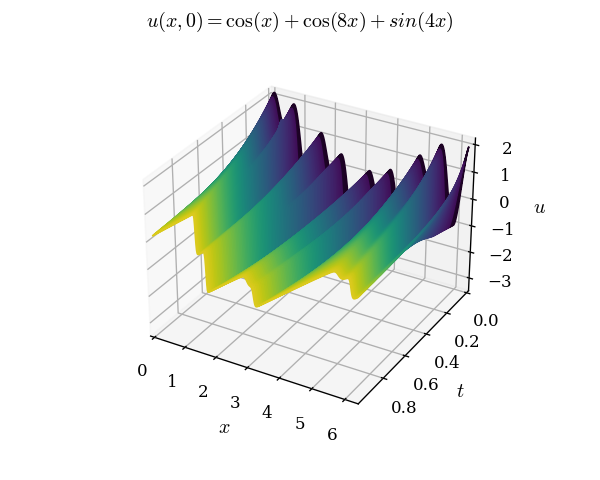

In [5]:
%matplotlib widget
fig, ax, v_cmap = plot_3d_evolution(x_vals, t_vals, u, cmap_name="viridis")
fig.set_label("Evolución de la Ecuación de Burgers mediante Diferencias Finitas")
# fig.suptitle(r"$u(x, 0) = \sin(x)$")
fig.suptitle(r"$u(x, 0) = \cos(x) + \cos(8x) + sin(4x)$")
plt.show()

Variando las condiciones iniciales y de la simulación pueden observarse diversos comportamientos (convergencia de múltiples picos a un único pico, decaimiento de la amplitud, etc.) pero en todos los casos se observa la aparición de frentes de onda (en tanto la condición inicial no sea nula como se explorará abajo). Dicho eso, para tiempos largos posteriores a la aparición del frente de onda, la solución numérica se vuelve inestable y diverge, comportamiento que esperaba sea controlado por el término difusivo.

La divergencia de la solución podría deberse en este caso o a la debilidad del término difusivo o a una limitación del método de integración, y en particular creo que se debe a la segunda opción siendo el método de Euler para el paso temporal un método inestable para este problema.

### d)

In [6]:
u = np.empty([nx, nt])  # Array con la velocidad
u[:, 0] = 0  # CI: constantemente cero

# Aplico el método de Euler para la integración temporal
for n in range(nt - 1):
    u[:, n+1] = u[:, n] + dt * (
        - (D_1 @ u[:, n]) @ np.diag(u[:, n])  # du/dx * u
        + nu * D_2 @ u[:, n]  # nu * d^2u/dx^2
    )

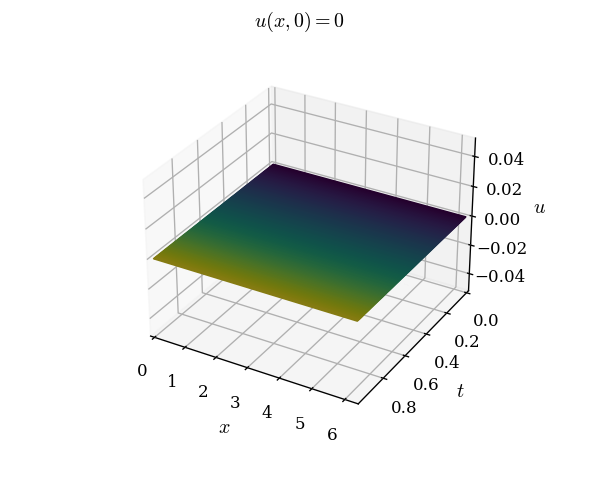

In [7]:
%matplotlib widget
fig, ax, v_cmap = plot_3d_evolution(x_vals, t_vals, u, cmap_name="viridis")
fig.set_label("Evolución de la Ecuación de Burgers mediante Diferencias Finitas")
fig.suptitle(r"$u(x, 0) = 0$")
plt.show()

Integrando en el tiempo a partir de $u(x, 0) = 0$ el método de diferencias finitas con Euler permite obtener satifactoriamente $u(x, t) = 0$ para todo $t$.

In [8]:
# Cerramos forzozamente los plots interactivos de la sección
plt.close("all")

## **Ejercicio 3: Burgers con métodos pseudoespectrales**

Implementá un método de Fourier con condiciones de contorno periódicas en el dominio $x \in [0,2\pi)$ para resolver numericamente la ecuación de Burgers, considerando las mismas condiciones iniciales del ejercicio anterior y utilizando un método de Runge Kutta de orden dos como integrador temporal.

$\bf a)$ Integrá hasta $t_f = 4$ considerando los siguientes parámetros: $\nu = 0$, $N_x = 512$ puntos de grilla y $\Delta t = 1\times10^{-3}$, verificá cualitativamente la solución hallada y estudia la conservación de la energía. *Ayuda: podes calcular la energía (a menos de una constante) dado un arreglo* $u[t,x]$ como `E = np.mean(u**2, axis=1)`

$\bf b)$ Considerando los siguientes parámetros: $\nu = 1\times 10^{-2}$ con $N_x = 512$ puntos de grilla y $\Delta t = 1\times10^{-3}$, graficá la solución obtenida ($u(x,t)$) hasta que la amplitud inicial cae a la mitad. Describi
cualitativamente la dinámica.

$\bf c)$ Que sucede si se  aumenta la viscocidad a $\nu = 1\times 10^{-1}$? Y si se la disminuye a $\nu = 1\times 10^{-3}$?.



---

**Resolución aquí**


---






En este caso, el esquema de Runge Kutta de orden dos aplicado en el espacio de Fourier sería:
$$\hat{u}_{n+1} = \hat{u}_{n} + \mathrm{d}t \cdot \phi\left(t_n + \frac{\mathrm{d}t}{2}, \hat{u}_n  + \frac{\mathrm{d}t}{2}\phi\left(t_n, \hat{u}_n\right)\right)$$
Para obtener la expresión de $\phi$ aplico la transformada de Fourier a la ecuación de Burgers:
$$\frac{\partial u}{\partial t} = - u \frac{\partial u}{\partial x} + \nu \frac{\partial^2 u}{\partial x^2}$$
$$\Rightarrow \mathcal{F}\left[\frac{\partial u}{\partial t}\right] = - \mathcal{F}\left[u  (\mathcal{F^{-1}}[i k u])\right] - \nu k^2 \hat{u}$$
$$\phi(t_n, \hat{u}_n) = \frac{\partial}{\partial t}\mathcal{F}\left[u\right]= - \mathcal{F}\left[u  (\mathcal{F^{-1}}[i k u])\right] - \nu k^2 \hat{u}$$

In [30]:
def evol(u: ArrayLike, k: ArrayLike, nu: float, N: float, dt: float):
    """Evoluciona en el tiempo la PDE usando el método pseudoespectral y \
Runge-Kutta de segundo orden.
    """
    u_hat = np.fft.rfft(u)  # Transformamos al espacio de Fourier
    u_hat_inicial = u_hat  # Guardamos el estado inicial
    for ord in [2,1]:  # Bucle para el Runge-Kutta
        D = dt/ord
        u_ux_hat = compute_advection(u_hat, k, N)
        u_hat = u_hat_inicial + D*(-u_ux_hat - nu*(k**2)*u_hat)  # Integramos en el tiempo
        u_hat[int(N/3):] = 0  # Dealiasing (eliminemos modos espúreos!)
    u_nuevo = np.fft.irfft(u_hat)  # Vuelva del espacio de Fourier
    return u_nuevo

def compute_advection(u_hat,k,N):
    """Calcula u*ux usando el método pseudoespectral y devuelve el resultado \
en el espacio Fourier.
    """
    ux_hat = 1j*k*u_hat  # Derivamos
    u = np.fft.irfft(u_hat)
    ux = np.fft.irfft(ux_hat)
    u_ux_hat = np.fft.rfft(u * ux)
    return u_ux_hat

In [31]:
# Defino mis puntos en el espacio real y los modos para el espacio de Fourier
nx = 512
tf = 1
dt = 1e-3
L = 2 * np.pi

x_vals = np.linspace(0, L, nx, endpoint=True)  # Coordenada espacial en [0,2*pi]
t_vals = np.arange(0, tf + dt/2, dt)  # Tiempo
nt = t_vals.size
# Números de onda ordenados como en la FFT
k_vals = np.fft.rfftfreq(nx, d=(x_vals[1] - x_vals[0])) * 2 * np.pi

Descomentando las lineas 3 a 6 en la siguiente celda pueden recuperarse las condiciones iniciales del punto anterior para el caso $\nu = 10^{-2}$:

In [32]:
nu = 1e-2
u = np.empty([nx, nt])  # Array con la velocidad
# u[:, 0] = np.sin(x_vals)  # CI: senoidal pura
u[:, 0] = np.cos(x_vals) + np.cos(8*x_vals) + np.sin(4*x_vals)  # CI: suma de armónicas
# u[:, 0] = np.exp(- (x_vals - L/2)**2 / 0.5**2)  # CI: gaussiana
# u[:, 0] = 0  # CI: constantemente cero

# Aplico el método de Euler para la integración temporal
for n in range(nt - 1):
    u[:, n+1] = evol(u[:, n], k_vals, nu, nx, dt)

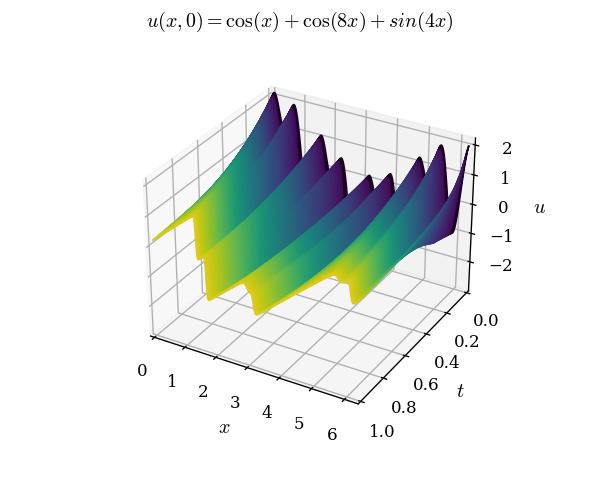

In [33]:
%matplotlib widget
fig, ax, v_cmap = plot_3d_evolution(x_vals, t_vals, u, cmap_name="viridis")
fig.set_label("Evolución de la Ecuación de Burgers mediante Método Pseudoespectral")
fig.suptitle(r"$u(x, 0) = \cos(x) + \cos(8x) + sin(4x)$")
plt.show()

En general se observan los mismos comportamientos que en punto anterior para estaas condiciones. Dejo graficado el caso $u(x, 0) = \cos(x) + \cos(8x) + sin(4x)$ donde se observa a grandes rasgos la misma dinámica de convergencia de los frentes de onda, sin comportamientos inesperados (como los que se observaran a continuación en este ejercicio).

### a)

In [45]:
# Defino mis puntos en el espacio real y los modos para el espacio de Fourier
nx = 512
tf = 4
dt = 1e-3
L = 2 * np.pi

x_vals = np.linspace(0, L, nx, endpoint=True)  # Coordenada espacial en [0,2*pi]
t_vals = np.arange(0, tf + dt/2, dt)  # Tiempo
nt = t_vals.size
# Números de onda ordenados como en la FFT
k_vals = np.fft.rfftfreq(nx, d=(x_vals[1] - x_vals[0])) * 2 * np.pi

In [46]:
nu = 0
u = np.empty([nx, nt])  # Array con la velocidad
u[:, 0] = np.sin(x_vals)  # CI: senoidal pura
# u[:, 0] = np.cos(x_vals) + np.cos(8*x_vals) + np.sin(4*x_vals)  # CI: suma de armónicas
# u[:, 0] = np.exp(- (x_vals - L/2)**2 / 0.5**2)  # CI: gaussiana
# u[:, 0] = 0  # CI: constantemente cero

# Aplico el método de Euler para la integración temporal
for n in range(nt - 1):
    u[:, n+1] = evol(u[:, n], k_vals, nu, nx, dt)

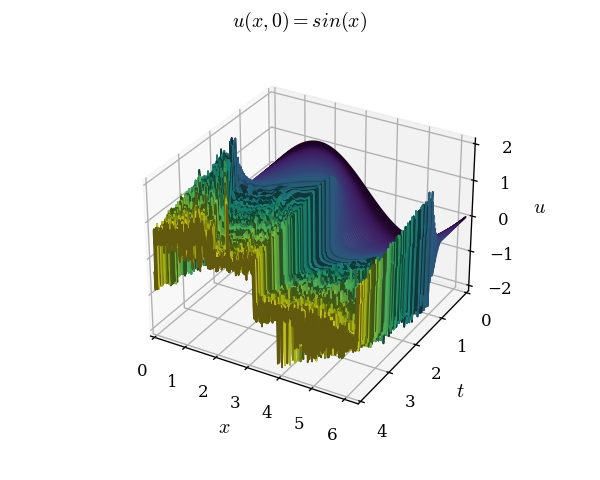

In [47]:
%matplotlib widget
fig, ax, v_cmap = plot_3d_evolution(x_vals, t_vals, u, cmap_name="viridis")
fig.set_label("Evolución de la Ecuación de Burgers mediante Método Pseudoespectral")
fig.suptitle(r"$u(x, 0) = sin(x)$")
plt.show()

Como se observa en el gráfico de arriba la solución se comporta de manera "razonable" durante aproximadamente el primer segundo de simulación, pero luego rápidamente comienzan a exitarse modos altos  del estilo Gibbs alrededor de la discontinuidad que rápidamente se propagan por toda la solución integrada. Esto se debe en principio a que, dado el caso $\nu = 0$, no hay nada que "le saque energía" a esos modos altos y mantenga bajo control la onda de choque, que integrada por estos métodos termina filtrando energía a modos aleatorios.

Abajo grafiqué la energía (que en principio debería conservarse dado $\nu = 0$) para observar este efecto más en detalle:

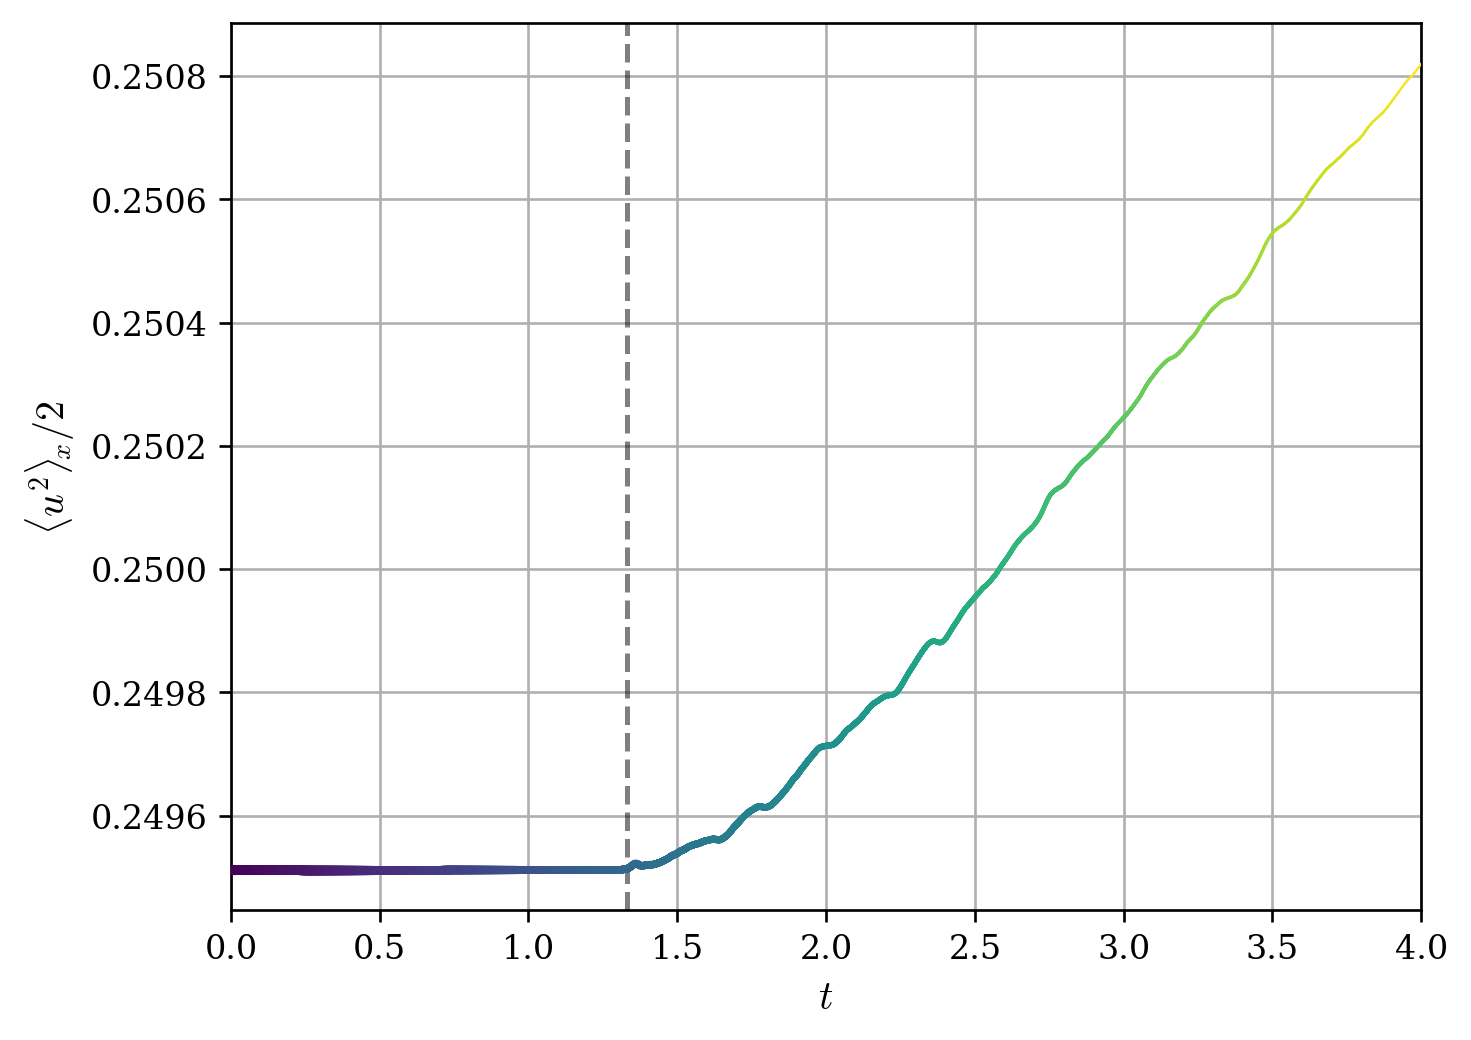

In [48]:
plt.close("all")
%matplotlib inline
ax, colormap = plot_colorline(t_vals, t_vals, np.mean(u**2, axis=0, )/2, cmap_name="viridis")
idx_pendiente_de_choque = np.argmin(np.diff(u, axis=0).min(axis=0))  # busco el índice de la menor pendiente
ax.axvline(t_vals[idx_pendiente_de_choque], ls="--", c="k", alpha=0.5)
ax.grid()
ax.set_xlabel(r"$t$")
ax.set_xlim(t_vals.min(), t_vals.max())
ax.set_ylabel(r"$\langle u^2 \rangle\!_x / 2$")
plt.show()

En esta figura puede observarse con facilidad que la energía comienza a dispararse a partir del instante en el que la pendiente del frente de ondas alcanza un mínimo (máximo en términos absolutos), momento en el que se aproxima a la discontinuidad y comienza a aparecer el fenómeno de Gibbs.

### b)

In [101]:
nu = 1e-2
u = [  # Lista de arrays con la velocidad
    np.sin(x_vals),  # CI: senoidal pura
    # np.cos(x_vals) + np.cos(8*x_vals) + np.sin(4*x_vals)  # CI: suma de armónicas
]

# Aplico el método de Euler para la integración temporal
n = 0
while (u[-1].max() - u[-1].min()) > (u[0].max() - u[0].min()) / 2:
    u.append(evol(u[n], k_vals, nu, nx, dt))
    n += 1
u = np.array(u).T
t_vals = np.arange(0, (n + 0.5)*dt, dt)  # Tiempo

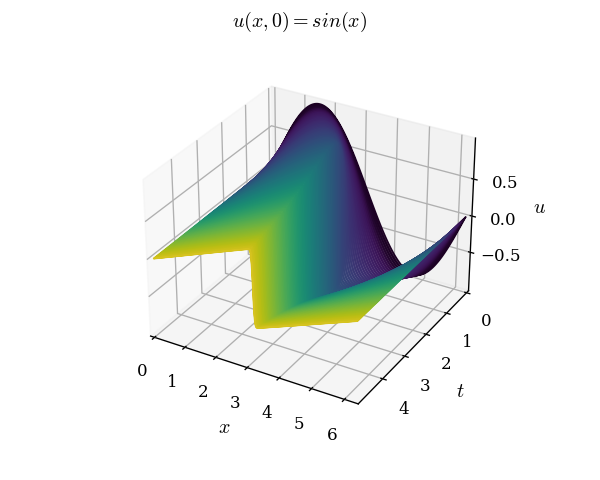

In [102]:
%matplotlib widget
fig, ax, v_cmap = plot_3d_evolution(x_vals, t_vals, u, cmap_name="viridis")
fig.set_label("Evolución de la Ecuación de Burgers mediante Método Pseudoespectral")
fig.suptitle(r"$u(x, 0) = sin(x)$")
plt.show()

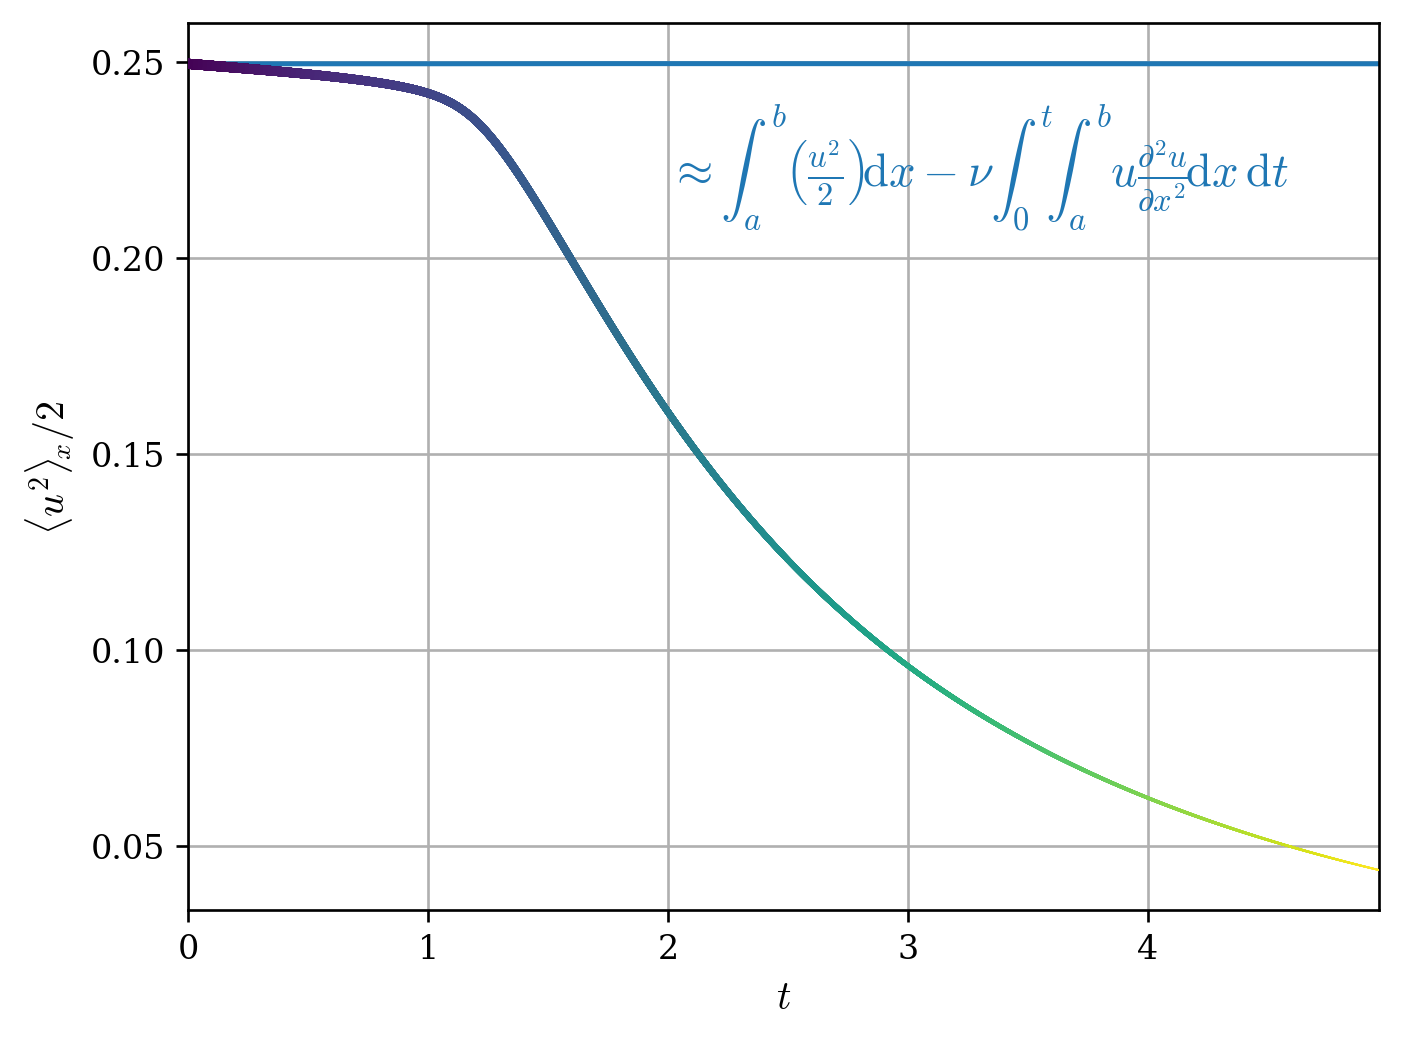

In [103]:
plt.close("all")
%matplotlib inline
energy_vals = np.mean(u**2, axis=0, )/2
ax, colormap = plot_colorline(t_vals, t_vals, energy_vals, cmap_name="viridis")
de_dt = nu * np.mean(u * np.fft.irfft(-(k_vals**2) * np.fft.rfft(u, axis=0).T, axis=1).T, axis=0)
ax.plot(t_vals, energy_vals - np.cumsum(de_dt)*dt)
ax.text(
    2, 0.24,
    r"$\approx \int_a^b \left(\frac{u^2}{2}\right) \!\mathrm{d}x - \nu \int_0^t\! \int_a^b u \frac{\partial^2 u}{\partial x^2} \!\mathrm{d}x\,\mathrm{d}t$",
    va="top", ha="left", color="C0", fontsize=14
)
ax.grid()
ax.set_xlabel(r"$t$")
ax.set_xlim(t_vals.min(), t_vals.max())
ax.set_ylabel(r"$\langle u^2 \rangle\!_x / 2$")
plt.show()

Nuevamente para estos casos con $\nu = 10^{-2}$ la solución obtenida presenta el comportamiento esperado: convergencia de los extremos hacia el origen con la aparición de un frente de ondas casi vertical y una disminución en la amplitud de la onda.

Luego, puede notarse que para todos los tiempos la solución pareciera (a simple vista) satisfacer la relación derivada en 1.b):
$$\frac{\partial}{\partial t} \int\limits_a^b \left(\frac{u^2}{2}\right) \!\mathrm{d}x = \nu \int\limits_a^b u \frac{\partial^2 u}{\partial x^2} \!\mathrm{d}x,$$
donde en el gráfico anterior se integró de ambos lados respecto del tiempo para mostrar como la diferencia de estos términos es aproximadamente constante en el tiempo.

### c)
Para el caso $\nu = 10^{-1}$ se observó que la solución explotaba a los pocos casos, por lo que se truncó la evolución en el 12° paso:

In [64]:
nu = 1e-1
u = [  # Lista de arrays con la velocidad
    np.sin(x_vals),  # CI: senoidal pura
]

# Aplico el método de Euler para la integración temporal
n = 0
while n < 12:  # Condición extra para evitar "explosión"
    u.append(evol(u[n], k_vals, nu, nx, dt))
    n += 1
u = np.array(u).T
t_vals = np.arange(0, (n + 0.5)*dt, dt)  # Tiempo

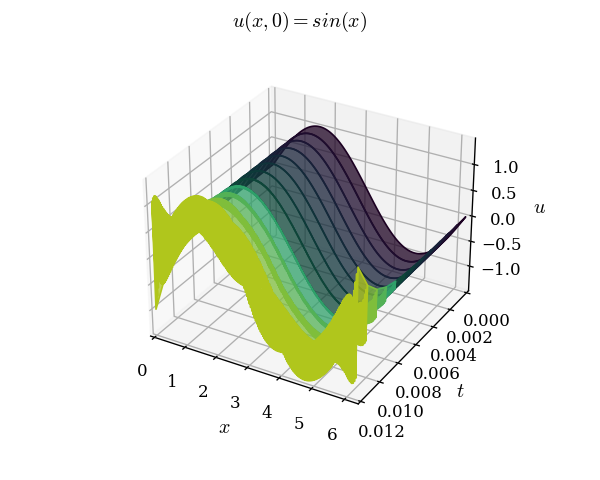

In [65]:
%matplotlib widget
fig, ax, v_cmap = plot_3d_evolution(x_vals, t_vals, u, cmap_name="viridis")
fig.set_label("Evolución de la Ecuación de Burgers mediante Método Pseudoespectral")
fig.suptitle(r"$u(x, 0) = sin(x)$")
plt.show()

Este comportamiento resulta extraño dado que se lo observa en el caso de alta difusividad. La explicación a la que llegamos tras una breve discusión con Julian fue que el integrador RK2 resulta inestable para una PDE en estas condiciones, pero los detalles que motivan esta explicación se me siguen escapando.

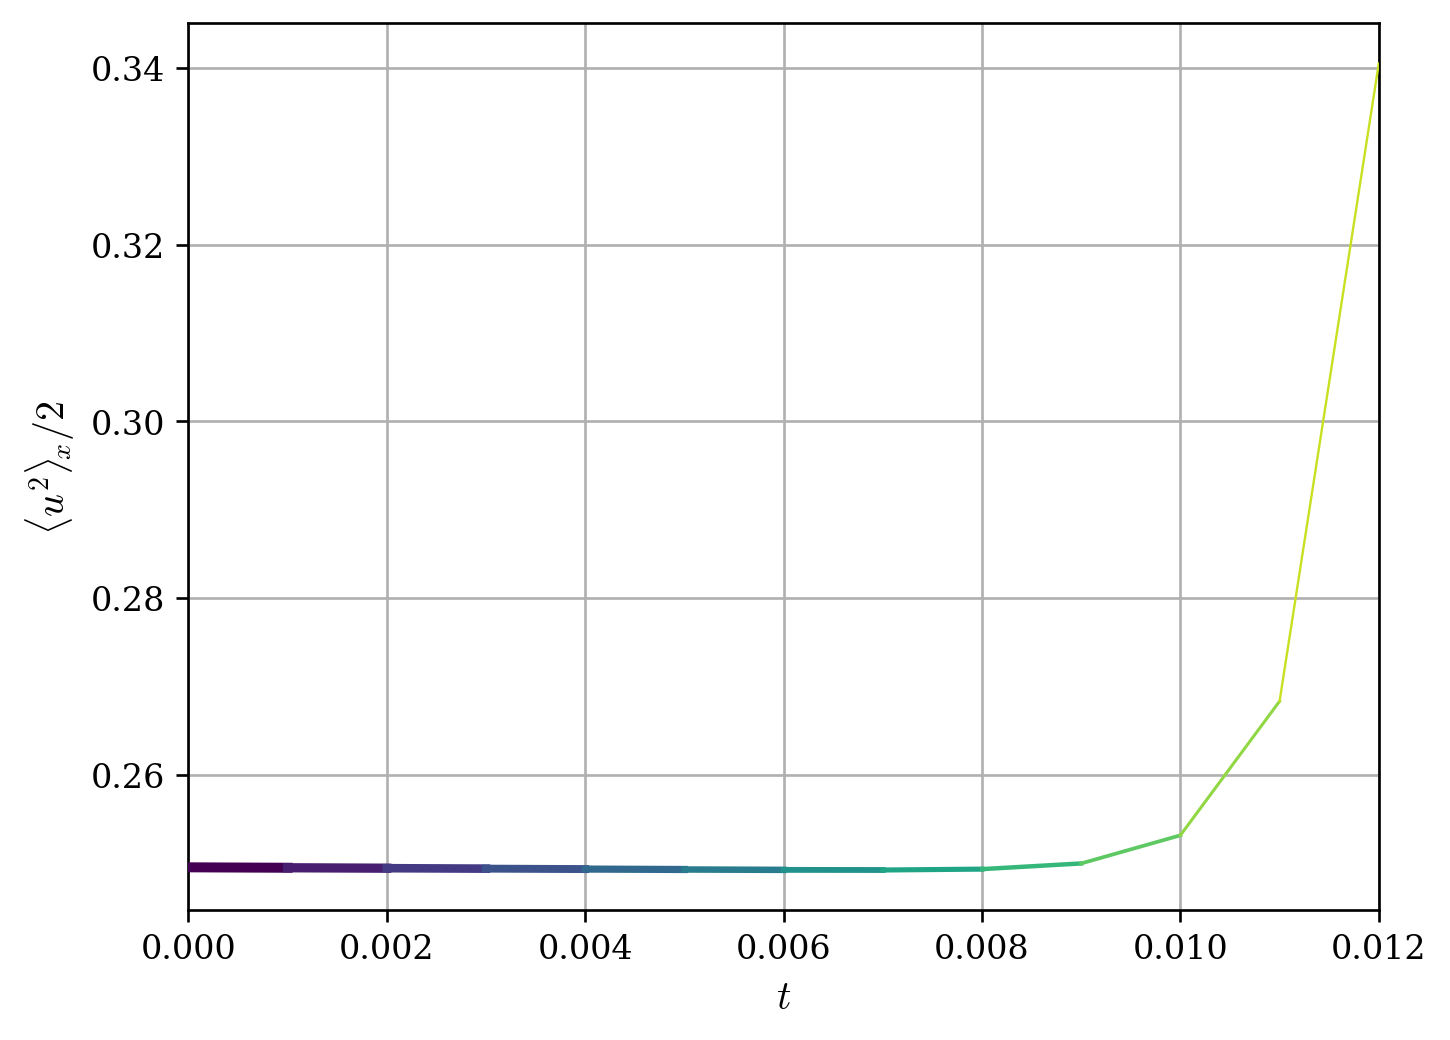

In [67]:
plt.close("all")
%matplotlib inline
energy_vals = np.mean(u**2, axis=0, )/2
ax, colormap = plot_colorline(t_vals, t_vals, energy_vals, cmap_name="viridis")
# de_dt = nu * np.mean(u * np.fft.irfft(-(k_vals**2) * np.fft.rfft(u, axis=0).T, axis=1).T, axis=0)
# ax.plot(t_vals, energy_vals - np.cumsum(de_dt)*dt)
ax.grid()
ax.set_xlabel(r"$t$")
ax.set_xlim(t_vals.min(), t_vals.max())
ax.set_ylabel(r"$\langle u^2 \rangle\!_x / 2$")
plt.show()

Dicho eso, el aumento en la energía observado es consistente con las limitaciones conocidas de RK2 que tienden a inyectar energía en el sistema. 

Por su parte, para $\nu = 10^{-3}$ se pudo proceder con una integración normal sin mayores inconvenientes. A continuación propuse una solución distinta de la senoidal para observar un gráfico cualitativamente distinto de el del punto 3.b)

In [71]:
nu = 1e-3
u = [  # Lista de arrays con la velocidad
    # np.sin(x_vals),  # CI: senoidal pura
    np.cos(x_vals) + np.cos(8*x_vals) + np.sin(4*x_vals)  # CI: suma de armónicas
    ]

# Aplico el método de Euler para la integración temporal
n = 0
while ((u[-1].max() - u[-1].min()) > (u[0].max() - u[0].min()) / 2):
    u.append(evol(u[n], k_vals, nu, nx, dt))
    n += 1
u = np.array(u).T
t_vals = np.arange(0, (n + 0.5)*dt, dt)  # Tiempo

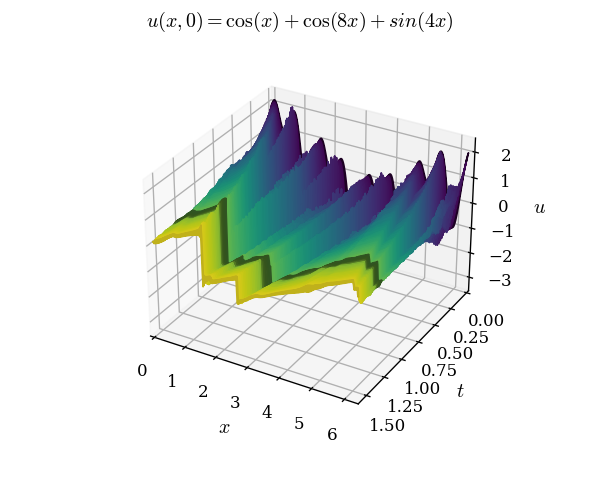

In [81]:
%matplotlib widget
fig, ax, v_cmap = plot_3d_evolution(x_vals, t_vals, u, cmap_name="viridis")
fig.set_label("Evolución de la Ecuación de Burgers mediante Método Pseudoespectral")
# fig.suptitle(r"$u(x, 0) = sin(x)$")
fig.suptitle(r"$u(x, 0) = \cos(x) + \cos(8x) + sin(4x)$")

# ax.set_zlim(-1, 1)
plt.show()
%matplotlib inline

Para la solución graficada pueden observarse la unión de los frentes de onda a medida que avanza el tiempo, con la aparición de fenomenos de Gibbs apreciables a simple vista pero que no se propagan en toda la solución como pasaba a $\nu = 0$.

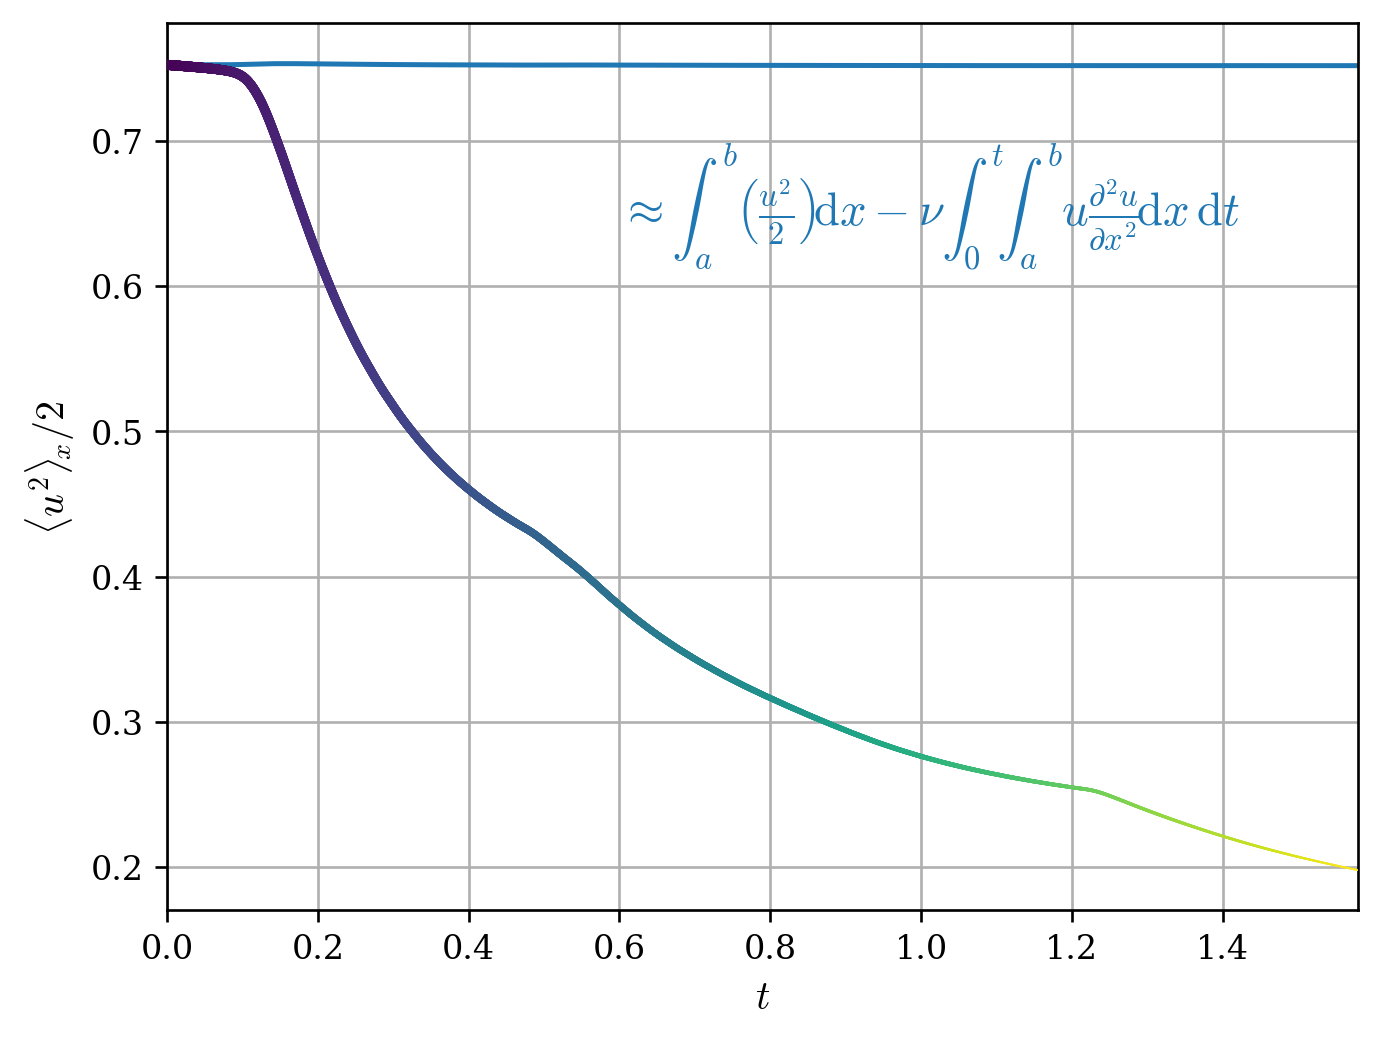

In [82]:
plt.close("all")
%matplotlib inline
energy_vals = np.mean(u**2, axis=0, )/2
ax, colormap = plot_colorline(t_vals, t_vals, energy_vals, cmap_name="viridis")
de_dt = nu * np.mean(u * np.fft.irfft(-(k_vals**2) * np.fft.rfft(u, axis=0).T, axis=1).T, axis=0)
ax.plot(t_vals, energy_vals - np.cumsum(de_dt)*dt)
ax.text(
    0.6, 0.7,
    r"$\approx \int_a^b \left(\frac{u^2}{2}\right) \!\mathrm{d}x - \nu \int_0^t\! \int_a^b u \frac{\partial^2 u}{\partial x^2} \!\mathrm{d}x\,\mathrm{d}t$",
    va="top", ha="left", color="C0", fontsize=14
)
ax.grid()
ax.set_xlabel(r"$t$")
ax.set_xlim(t_vals.min(), t_vals.max())
ax.set_ylabel(r"$\langle u^2 \rangle\!_x / 2$")
plt.show()

Al graficar la energía resultan de interés los "bumps" (protuberancias?) en la curva que podrían estar asociadas o bien a la aparición de frentes o bien a su unión.

Y una vez más, calculando numéricamente la integral en el tiempo de los dos términos del balance derivado en 1.b) para esta solución se puede notar que por lo menos a simple vista esta cantidad se conserva.

Observando ahora en detalle la "recta azul" del balance, puede notarse que esta cantidad presenta picos allí donde la energía tenía las protuberancias, indicando quizá la energía inyectada al sistema por los fenómenos de Gibbs cuya amplitud es controlada por el término difusivo antes de que se propagen por el sistema como vimos en 3.a).

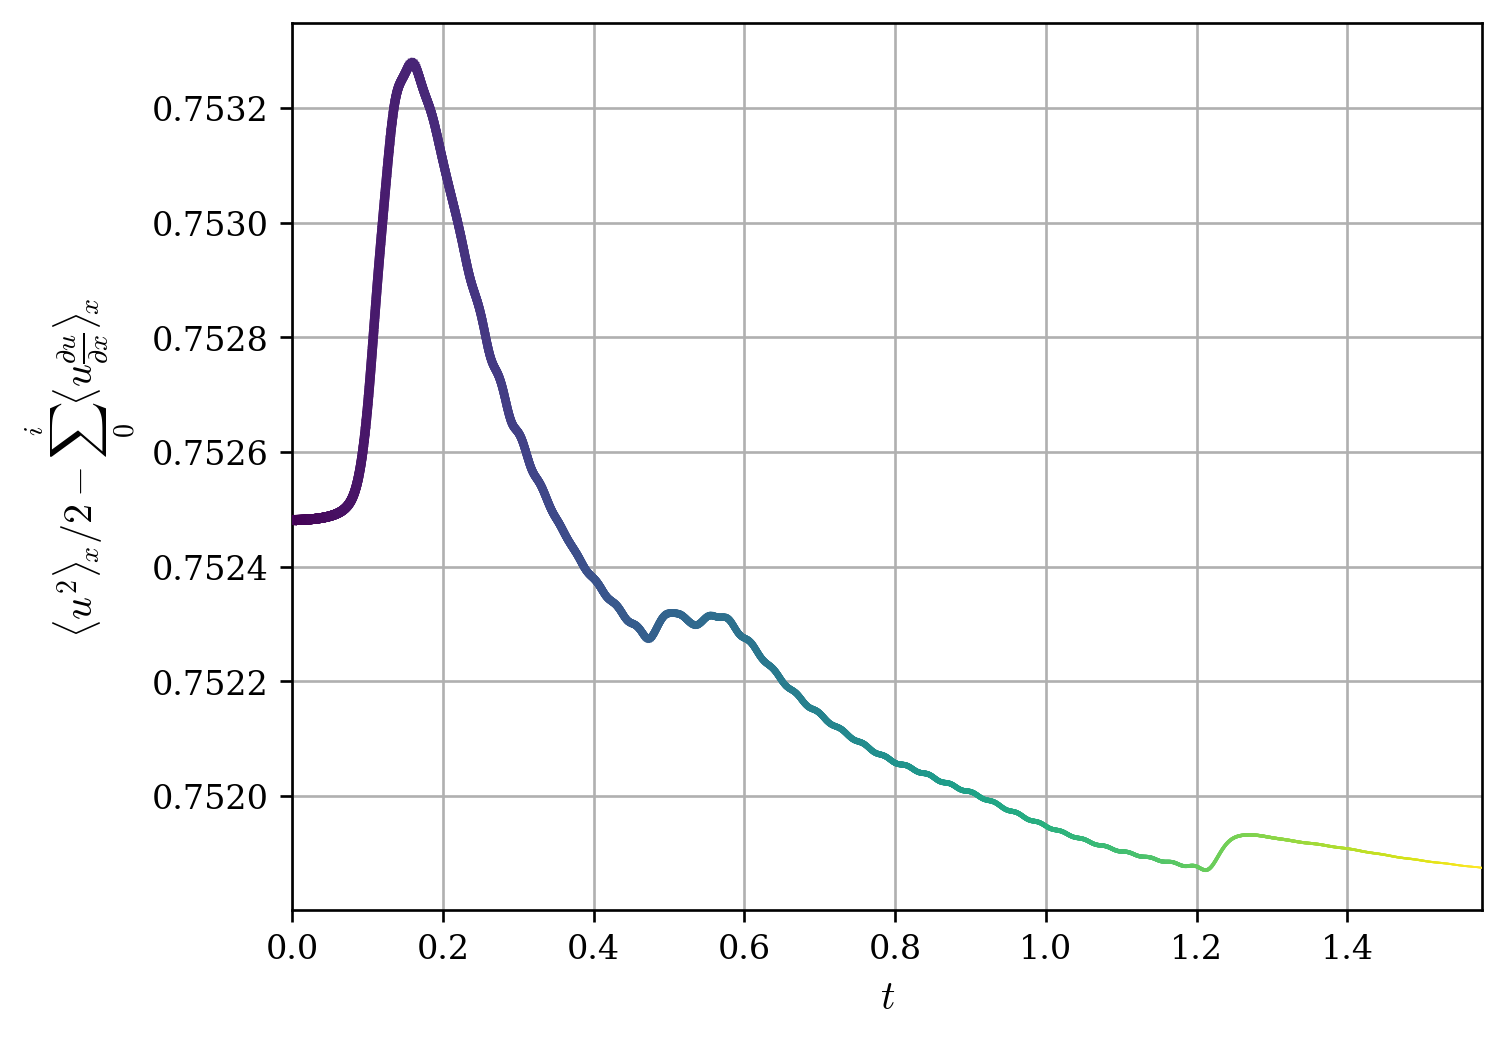

In [90]:
energy_vals = np.mean(u**2, axis=0, )/2
de_dt = nu * np.mean(u * np.fft.irfft(-(k_vals**2) * np.fft.rfft(u, axis=0).T, axis=1).T, axis=0)

ax, colormap = plot_colorline(
    t_vals, t_vals, energy_vals - np.cumsum(de_dt)*dt, cmap_name="viridis",
    # label=r"$\approx \int_a^b \left(\frac{u^2}{2}\right) \!\mathrm{d}x - \nu \int_0^t\! \int_a^b u \frac{\partial^2 u}{\partial x^2} \!\mathrm{d}x\,\mathrm{d}t$"
)
ax.grid()
# ax.legend()
ax.set_xlabel(r"$t$")
ax.set_xlim(t_vals.min(), t_vals.max())
ax.set_ylabel(r"$\langle u^2 \rangle\!_x / 2 - \sum_0^i \langle u \frac{\partial u}{\partial x}\rangle\!_x$")
plt.show()

In [106]:
plt.close("all")

## **Ejercicio 4: Burgers con PINNS**

Integre la ecuación de Burgers usando PINNs. En este caso, vamos a utilizar las PINNs como un integrador a partir de las condiciones iniciales.

Para ello, vamos a partir de una condición inicial $u_0(x,0) = \sin ( x)$ con $x \in [0,2 \pi]$. Además, vamos a poner condiciones de contorno tal que $u(0,t) = u(2 \pi,t) = 0$. Estos van a ser los datos que tenemos medidos del problema.


a) Usando la condición inicial descrita y con $\nu = 0$ use una PINN para integrar para $t \in [0,1]$. Grafique la solución de la red para distintos tiempos. Grafique $u(x,t)$ completo en todos los puntos donde evalua la física como una imagen. Interprete lo que ve. ¿Qué diferencias encuentra con lo visto en otros ejercicios? ¿Se cumple la conservación para la integral primera? [importante: Seleccione los parámetros por su cuenta]

b) Repita el punto $a$ pero con $\nu = 1 \times 10^{-2}$. Grafique para distintos tiempos y la matriz de  $u(x,t)$. Compare con la solución obtenida con métodos pseudoespectrales. Describa las diferencias que encuentra.

~~Importamos las librerías correspondientes~~
(moví los imports a la primera celda del notebook)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

~~Definimos la clase MLP~~
La clase `CustomActivationMLP` definida en `guias/utils` es análoga a la clase `MLP` que nos dieron pero permite además definir funciones de activación personalizadas.

Definimos las condiciones iniciales y condiciones de contorno

In [3]:
grid_size = 100
# Condiciones Iniciales
t_data_init = torch.zeros(grid_size).view(-1, 1)  # defina grid_size puntos entre 0 y 1   No olvidar .view(-1,1)
x_data_init = torch.linspace(0, 2 * torch.pi, grid_size).view(-1, 1)  # defina grid_size puntos entre 0 y 2pi No olvidar .view(-1,1)
y_data_init = torch.sin(x_data_init).view(-1, 1)  # defina la condicion inicial     No olvidar .view(-1,1)
input_init = torch.cat((x_data_init, t_data_init), dim=1)  # Junta las condiciones iniciales para que tengan la forma correcta
# Condiciones de Contorno
t_data_cc = torch.cat((t_data_init, t_data_init), dim=0).view(-1,1)  # grid_size puntos temporales dos veces
x_data_cc = torch.cat((torch.zeros(grid_size), torch.full((grid_size, ), 2 * torch.pi)), dim = 0).view(-1,1)  # grid_size puntos en 0 y grid_size en 2π
y_data_cc = torch.zeros(2 * grid_size).view(-1,1)  # 2·grid_size puntos que valen 0
input_cc = torch.cat((x_data_cc, t_data_cc), dim=1) # Los juntamos para que pueda ser input la red

Definimos los puntos para evaluar la física. Estos deberán ser una grilla de 100x100 en el tiempo y el espacio.

In [4]:
t_physics = torch.linspace(0, 1, grid_size)  # grid_size puntos de 0 a 1
x_physics = torch.linspace(0, 2 * torch.pi, grid_size)  # grid_size puntos de 0 a 2 pi
x_grid, t_grid = torch.meshgrid(x_physics, t_physics, indexing='ij')
x_grid = x_grid[:, :, None].requires_grad_(True)  # Agregamos una dimensión al final para que pueda ser input de la red
t_grid = t_grid[:, :, None].requires_grad_(True)  # Agregamos una dimensión al final para que pueda ser input de la red
input_physics = torch.cat((x_grid, t_grid), dim=-1)

Defina la red y el optimizador. Se recomienda para empezar a explorar una red con $8$ capas ocultas con $20$ neuronas cada una. Use el peso relativo entre la física y lo demás como 1.

In [5]:
# Definición de la red y optimizador
pinn = CustomFunctionMLP(
    sizes=[2, ] + [20, ] * 8 + [1, ],  # Lista de Capas propuesta
    # sizes=[2, ] + [10, ] * 4 + [1, ],  # Lista de Capas alternativa 1
    # sizes=[2, ] + [20, ] * 4 + [1, ],  # Lista de Capas alternativa 2
    # sizes=[2, ] + [30, ] * 4 + [1, ],  # Lista de Capas alternativa 3
    # sizes=[2, ] + [10, ] * 8 + [1, ],  # Lista de Capas alternativa 4
    # sizes=[2, ] + [30, ] * 8 + [1, ],  # Lista de Capas alternativa 5
    # sizes=[2, ] + [10, ] * 12 + [1, ],  # Lista de Capas alternativa 6
    # sizes=[2, ] + [20, ] * 12 + [1, ],  # Lista de Capas alternativa 7
    # sizes=[2, ] + [30, ] * 12 + [1, ],  # Lista de Capas alternativa 8
    activation=torch.tanh,  # Función de activación default
)
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)  # Repito de Guía 1

Complete con lo que sea necesario el loop de entrenamiento.

In [6]:
def train_burgers_solver(
    pinn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    iterations: int,
    initial_conditions_inputs: torch.Tensor,
    initial_conditions_labels: torch.Tensor,
    boundary_conditions_inputs: torch.Tensor,
    boundary_conditions_labels: torch.Tensor,
    physics_inputs: torch.Tensor,
    nu : float,
    loss_weights: tuple[float, float, float] = (1, 1, 1),
) -> tuple[int, ArrayLike]:
    loss_vals = np.empty((iterations, 3))
    interrumpted = False
    try:
        for epoch in range(iterations):
            optimizer.zero_grad()
            # Condiciones Iniciales
            yh_init = pinn(initial_conditions_inputs)  # Evalue las condiciones iniciales en la red
            loss1 = loss_weights[0] * torch.mean((yh_init - initial_conditions_labels)**2)  # Defina este error como el MSE de la condición inicial
            # Condiciones de Contorno
            yh_cc = pinn(boundary_conditions_inputs)  # Evalue las condiciones de contorno en la red
            loss2 = loss_weights[1] * torch.mean((yh_cc - boundary_conditions_labels)**2)  # Defina este error como el MSE de las condiciones de contorno
            # Condiciones de la Física
            yhp = pinn(physics_inputs)  # Evalue las colocaciones de la física en la red
            yhp_dx = torch.autograd.grad(yhp, x_grid, torch.ones_like(yhp), create_graph=True)[0]  # computamos u_x
            if nu != 0:
                yhp_dx2 = torch.autograd.grad(yhp_dx, x_grid, torch.ones_like(yhp), create_graph=True)[0]  # computamos u_xx
            else:
                yhp_dx2 = 0
            yhp_dt = torch.autograd.grad(yhp, t_grid, torch.ones_like(yhp), create_graph=True)[0]  # computamos u_t
            physics = yhp_dt + yhp*yhp_dx - nu*yhp_dx2  # Complete con la ecuación diferencial
            loss3 = loss_weights[2] * torch.mean(physics**2)  # Defina este error como el MSE de la ecuación diferencial en las colocaciones pesado por λ
            loss = loss1 + loss2 + loss3  # Sumamos todos los errores
            loss.backward()
            optimizer.step()
            with torch.autograd.no_grad():
                # print(epoch,'CI',float(loss1), 'CC', float(loss2), 'Física:',float(loss3),"Traning Loss:",float(loss.data))
                print(
                    f"{epoch+1: 5} CI MSE: {loss1: 5.4g}    CC MSE: {loss2: 5.4g}    ",
                    f"Phys MSE: {loss3: 5.4g}    Traning Loss: {loss.data: 5.4g}",
                    sep="", end="\r",
                ) #Imprimimos el error
                loss_vals[epoch] = [loss1, loss2, loss3]
    except KeyboardInterrupt:
        interrumpted = True
        loss_vals = loss_vals[:epoch]
    finally:
        print(
            f"{epoch+1: 5} CI MSE: {loss1: 5.4g}    CC MSE: {loss2: 5.4g}    ",
            f"Phys MSE: {loss3: 5.4g}    Traning Loss: {loss.data: 5.4g}",
            sep="",
        ) #Imprimimos el error
    if interrumpted:
        print(f"Training interrupted at epoch {epoch+1}/{iterations}.")
    return loss_vals

## a)

Hice el siguiente script para no tener que reentrenar la red cada vez que quiero probar algo nuevo. Lo que hace es guardar las redes entrenadas en archivos .pth (y trata de cargarlos si ya existen). De esta manera, puedo probar distintos parámetros sin tener que esperar a que la red se entrene cada vez.

El script también guarda los datos de perdida del entrenamiento en archivos .npz y otra información relevante en un archivo .json que es común para todos los modelos entrenados.

Todos los datos relacionados a los modelos entrenados se guardan en la carpeta `guias/modelos_entrenados/`.

In [7]:
model_name = "burgers_solver_tanh_08"

try:
    # Obtengo la información del modelo:
    model_info_dict = get_model_info(model_name)
    # Cargo el modelo:
    pinn = CustomFunctionMLP(sizes=model_info_dict["layers"], activation=torch.tanh)
    pinn.load_state_dict(torch.load(f"modelos_entrenados/{model_name}.pth"))
    # Cargo la información del entrenamiento:
    loss_vals = np.load(f"modelos_entrenados/{model_name}_loss.npy")
    epochs = loss_vals.shape[0]
    # Imprimo la información del modelo:
    print(f"Modelo {model_name} cargado:")
    display(model_info_dict)
    print(
            f"{epochs: 5} CI MSE: {loss_vals[-1, 0]: 5.4g}    ",
            f"CC MSE: {loss_vals[-1, 1]: 5.4g}    ",
            f"Phys MSE: {loss_vals[-1, 2]: 5.4g}",
            sep="",
        )  # Imprimimos el error
except FileNotFoundError as e:
    # Entreno el modelo:
    epochs = 5_000
    nu = 0
    pesos_perdida = (1, 1, 1)
    loss_vals = train_burgers_solver(
        pinn,
        optimizer,
        iterations=epochs, # Numero de iteraciones
        initial_conditions_inputs=input_init,
        initial_conditions_labels=y_data_init,
        boundary_conditions_inputs=input_cc,
        boundary_conditions_labels=y_data_cc,
        physics_inputs=input_physics,
        loss_weights=pesos_perdida,  # Peso para cada error
        nu=nu,  # Viscosidad de la ecuación de Burgers
    )
    epochs = loss_vals.shape[0]  # Actualizo por si se interrumpió el entrenamiento
    # Guardo el modelo entrenado:
    torch.save(pinn.state_dict(), f"modelos_entrenados/{model_name}.pth")
    # Guardo la información del entrenamiento:
    np.save(f"modelos_entrenados/{model_name}_loss.npy", loss_vals)
    # Guardo la información del modelo:
    models_info_dict = save_model_info(
        model_name=model_name,
        pinn=pinn,
        optimizer=optimizer,
        loss_weights=pesos_perdida,
        epochs=epochs,
        ci_description="sin(x) (N=100)",
        cc_description="u(0,t) = u(2pi,t) = 0 (N=200)",
        physics_description="u_t + u*u_x - nu*u_xx = 0 (N=100*100)",
        burgers_nu=nu,
    )
    display(models_info_dict[model_name])

Modelo burgers_solver_tanh_08 cargado:


{'layers': [2, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 1],
 'activation': 'tanh',
 'optimizer': 'Adam',
 'loss_weigths': {'IC': 1, 'CC': 1, 'Physics': 1},
 'epochs': 5000,
 'ci_description': 'sin(x) (N=100)',
 'cc_description': 'u(0,t) = u(2pi,t) = 0 (N=200)',
 'physics_description': 'u_t + u*u_x - nu*u_xx = 0 (N=100*100)',
 'burgers_nu': 0}

 5000 CI MSE:  0.0004076    CC MSE:  2.241e-06    Phys MSE:  0.001121


A continuación hice una breve comparación de las redes que entrené en términos de las funciones de perdida a lo largo del entrenamiento, donde los resultados (no muy sorprendentemente) indican que la red con más capas y neuronas es la que mejor se ajusta a los datos para el mismo número de iteraciones del loop de entrenamiento.

Dicho eso, el análisis resultó limitado al no considerar el tiempo que tardó cada red en entrenarse por el mismo número de epocas, por lo que no se puede concluir que la red con más capas y neuronas sea la más óptima en terminos de tiempo de entrenamiento.

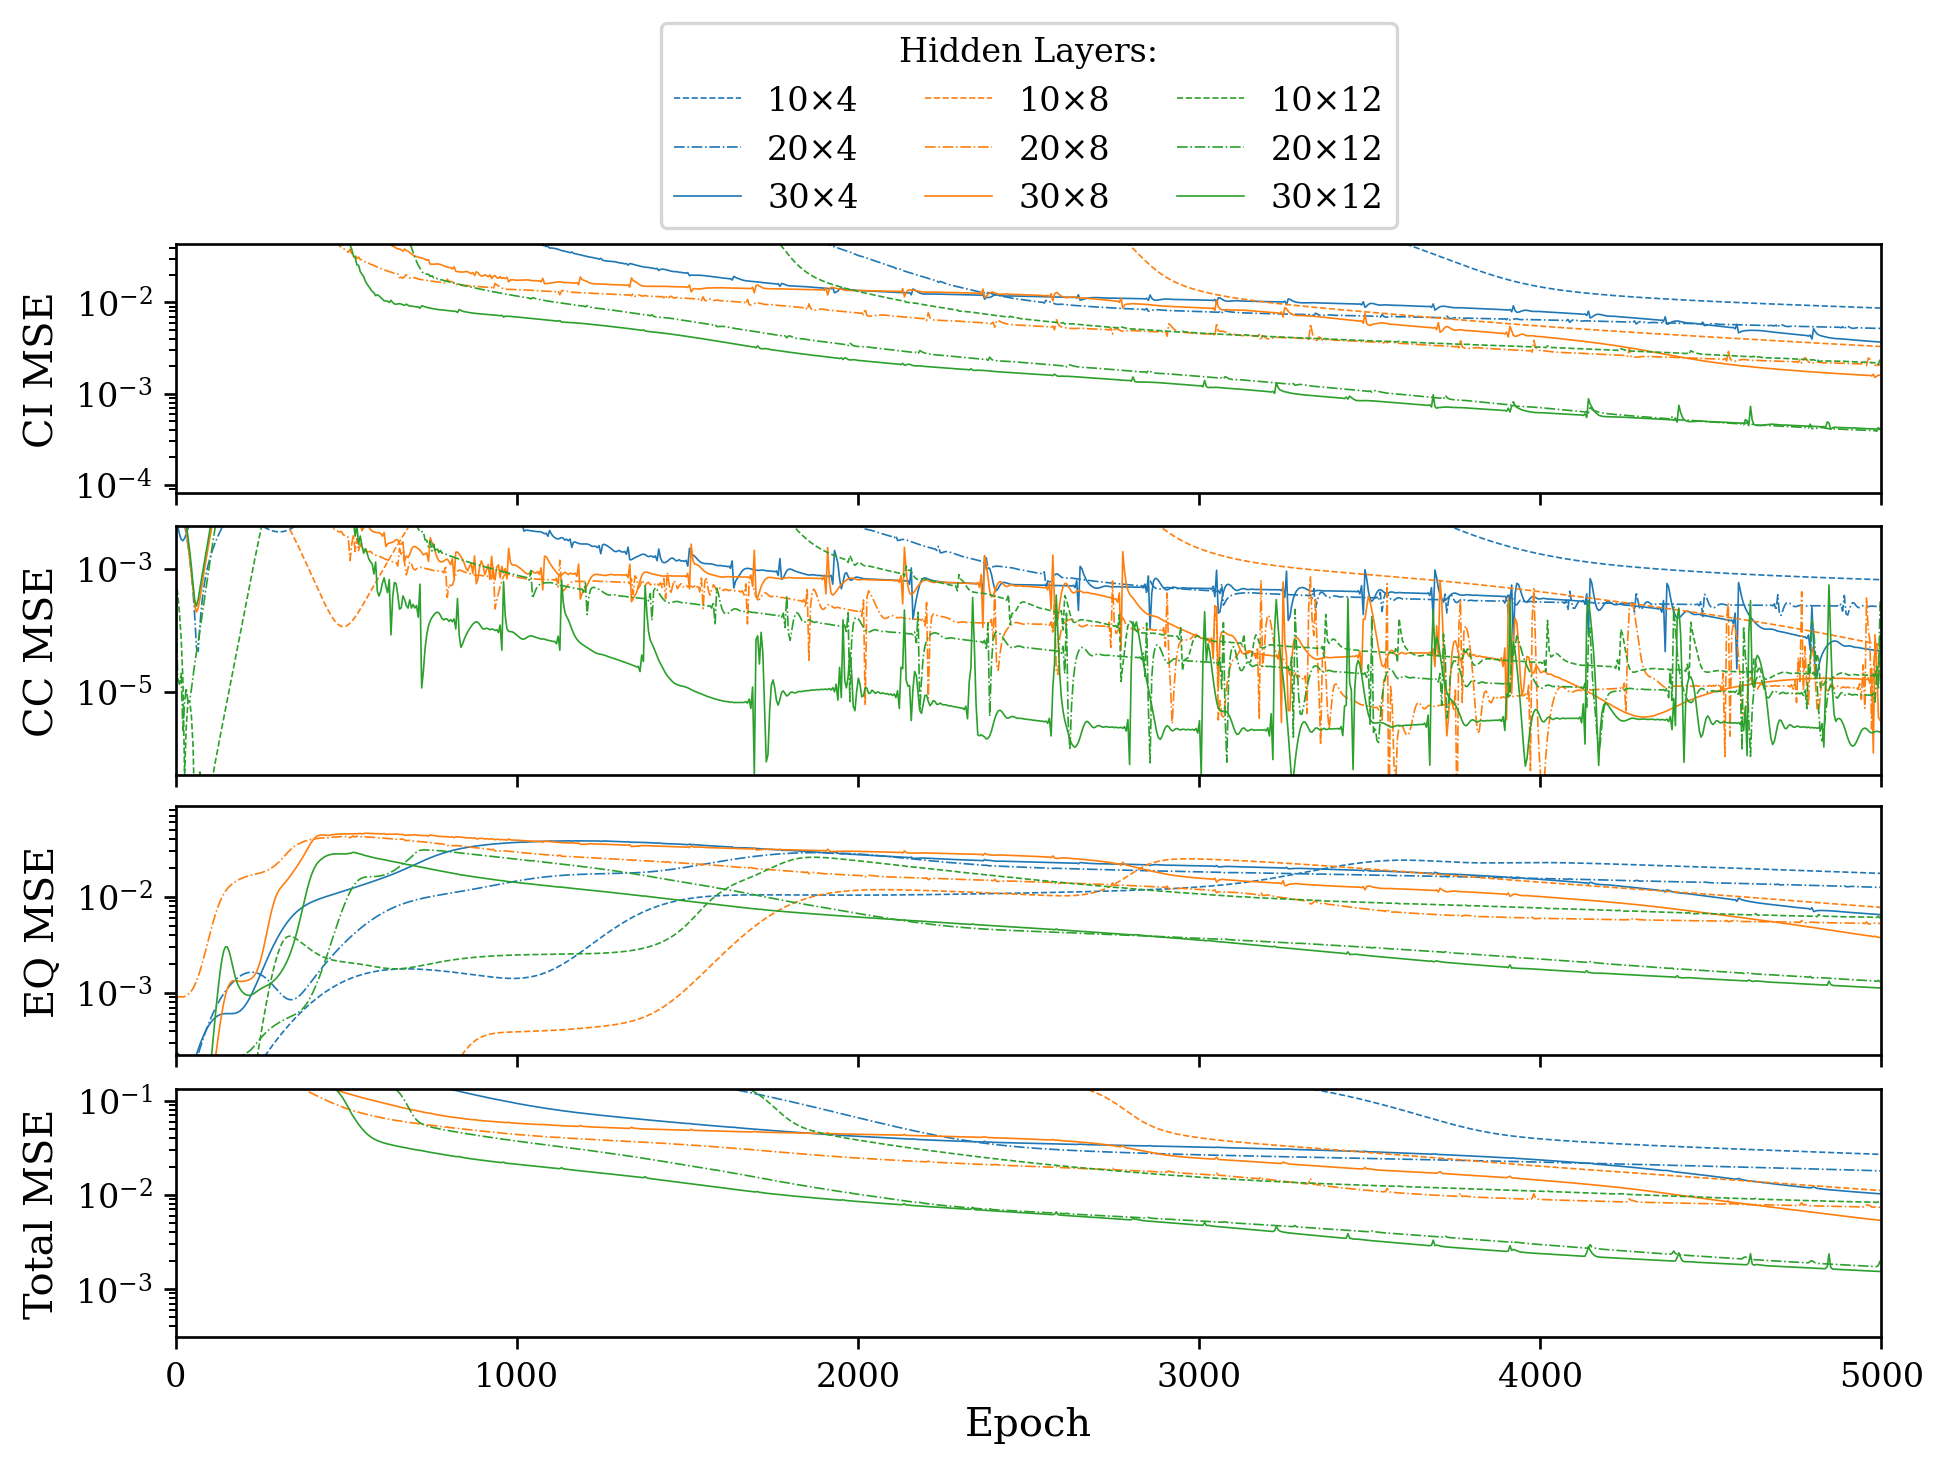

In [8]:
tags = {
    "burgers_solver_tanh_00": "20×8",
    "burgers_solver_tanh_01": "10×4",
    "burgers_solver_tanh_02": "20×4",
    "burgers_solver_tanh_03": "30×4",
    "burgers_solver_tanh_04": "10×8",
    "burgers_solver_tanh_05": "30×8",
    "burgers_solver_tanh_06": "10×12",
    "burgers_solver_tanh_07": "20×12",
    "burgers_solver_tanh_08": "30×12",
}
def get_model_style(model_name: str) -> dict:
    layers_str = tags[model_name]
    layer_count, layer_size = layers_str.split("×")
    colors = {"4": "C0", "8": "C1", "12": "C2"}
    linestyles = {"10": "--", "20": "-.", "30": "-"}
    return dict(
        color=colors[layer_size],
        linestyle=linestyles[layer_count],
    )

plot_extremes = np.ones((4, 2))
plot_extremes[:, 1] = 1e-3
fig, axs = plt.subplots(4, sharex=True, figsize=(8, 6), constrained_layout=True)
for model_name in [
    "burgers_solver_tanh_01",
    "burgers_solver_tanh_02",
    "burgers_solver_tanh_03",
    "burgers_solver_tanh_04",
    "burgers_solver_tanh_00",
    "burgers_solver_tanh_05",
    "burgers_solver_tanh_06",
    "burgers_solver_tanh_07",
    "burgers_solver_tanh_08"
]:
    loss_vals = np.load(f"modelos_entrenados/{model_name}_loss.npy")
    for loss_idx in range(3):
        final_loss = loss_vals[-1, loss_idx]
        if final_loss < plot_extremes[loss_idx, 0]:
            plot_extremes[loss_idx, 0] = final_loss
        if final_loss > plot_extremes[loss_idx, 1]:
            plot_extremes[loss_idx, 1] = final_loss
    final_loss = loss_vals[-1, :].sum()
    if final_loss < plot_extremes[3, 0]:
        plot_extremes[3, 0] = final_loss
    if final_loss > plot_extremes[3, 1]:
        plot_extremes[3, 1] = final_loss
    plot_training_loss(
        loss_vals,
        plot_every=5,
        axs=axs,
        ms=None, lw=0.5,
        **get_model_style(model_name),
        label=tags[model_name],
    )
# Extended legend over first ax:
axs[0].legend(title="Hidden Layers:", bbox_to_anchor=(0.5, 1), loc="lower center", ncol=3)
for ax, y_lim in zip(axs, plot_extremes):
    ax.set_ylim(y_lim[0]*0.2, y_lim[1]*5)
plt.show()

A continuación realicé un breve estudio de la energía para cada solución donde observe dos cosas que resultaron interesantes:
* Todas las redes tienen un distinto valor inicial de $E$ como consecuencia de que hayaron distintas soluciones para la condición inicial sin llegar a "aprenderla" lo suficiente. Esto implica la necesidad de darle un peso relativo mayor a la perdida de los datos de CI para que los resultados sean consistentes con el caso que se quiere integrar.
* Considerando el tiempo de integración "aprendido" (intervalo $t \in [0, 1]$) resulta consistente con pseudo-espectral en el sentido que aún no "explota" la energía. Dicho esto, la energía varía notablemente en el tiempo, conservandose mucho menos que en el caso de pseudo-espectral para este tiempo (notar que acá los valores varian en el orden de $10^{-2} \sim 10^{-3}$ mientras que en pseudo-espectral lo hacian en el orden de $10^{-4}$ aún despues de "romperse").

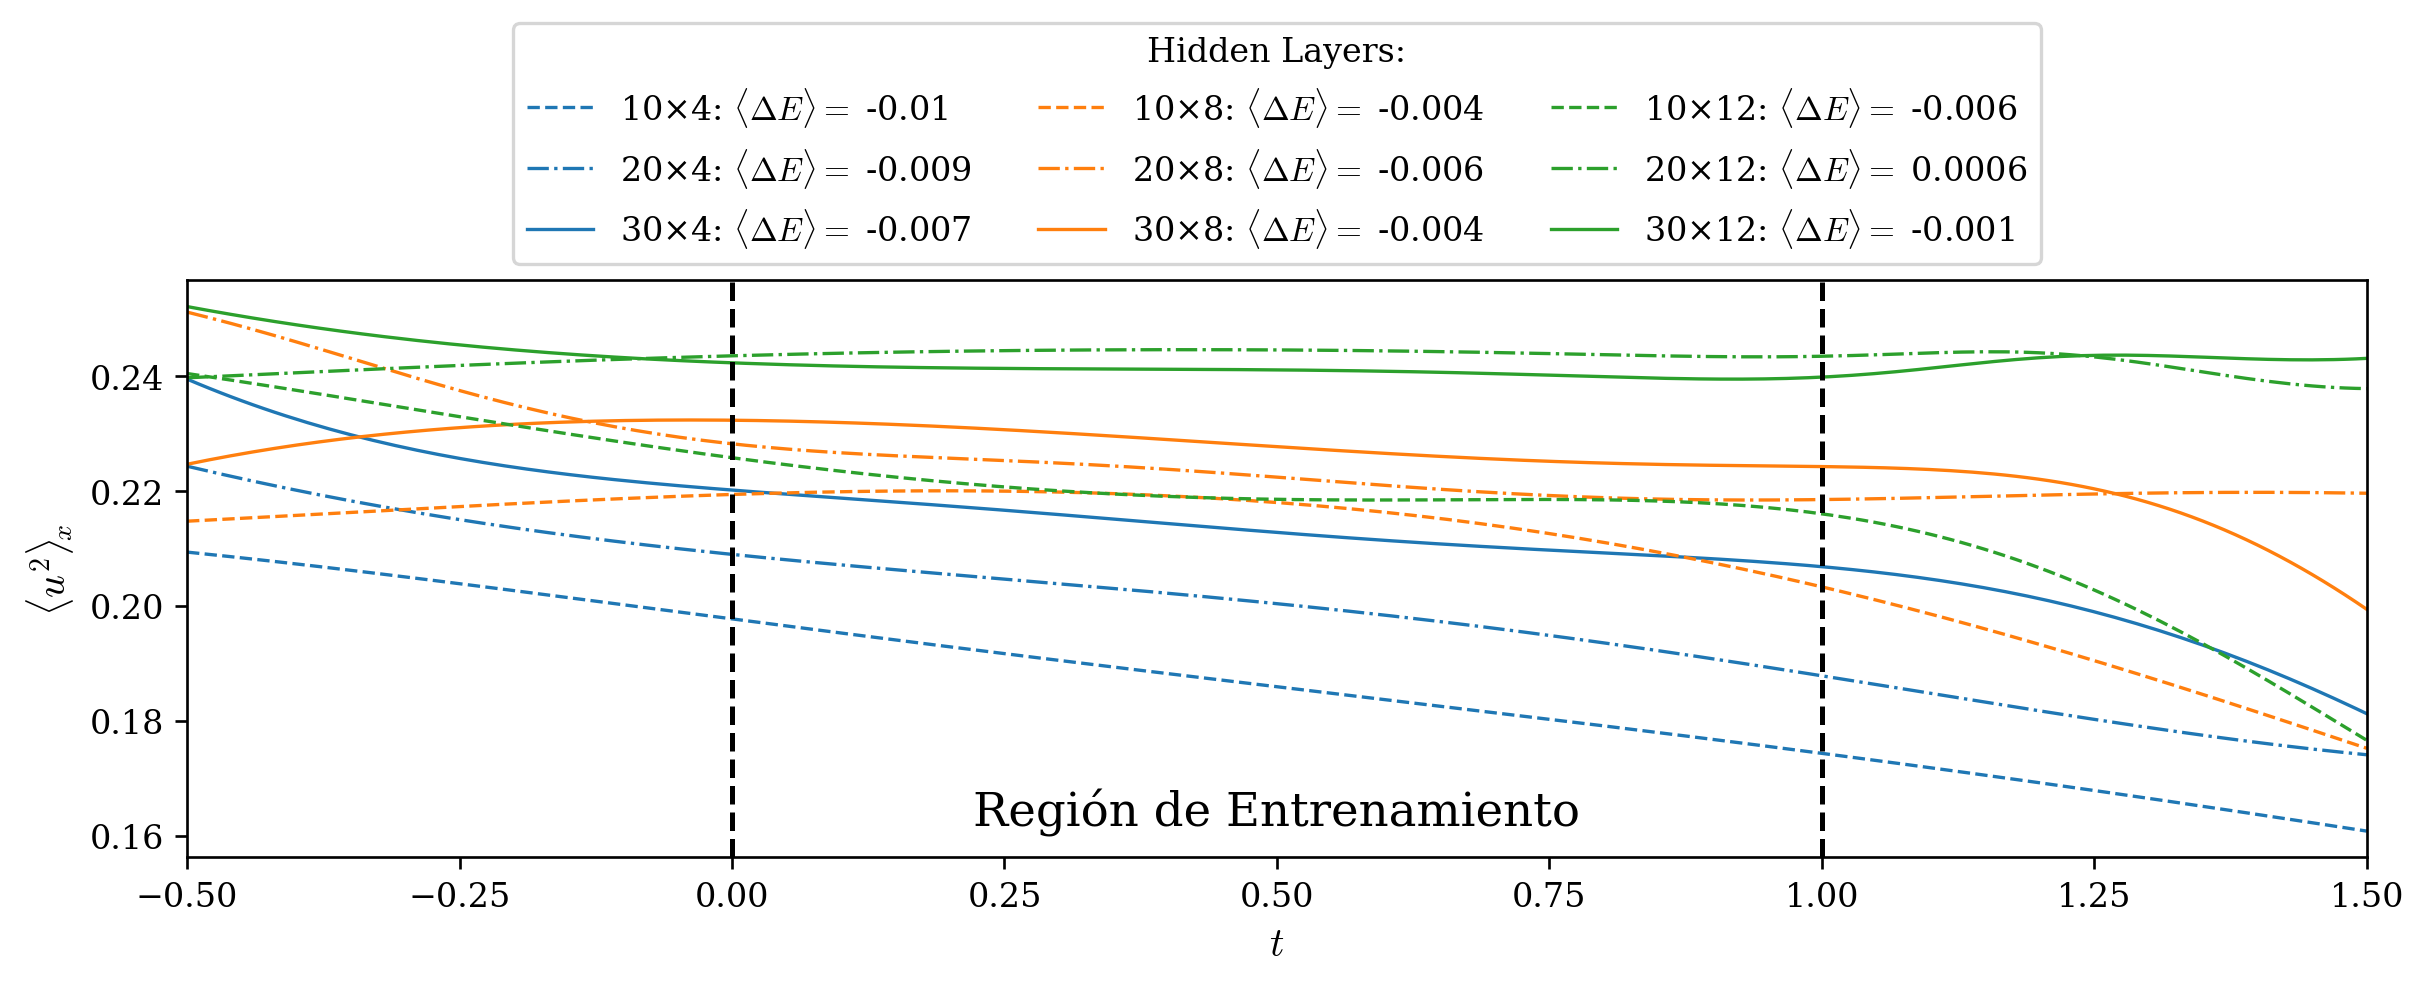

In [41]:
t_plot = torch.linspace(-0.5, 1.5, 200)  # Definimos muestra temporal para graficar
x_plot = torch.linspace(0, 2 * np.pi, 512)  # Definimos muestra espacial para graficar
xx_plot, tt_plot = np.meshgrid(x_plot, t_plot, indexing='ij')
xx_plot = xx_plot[:, :, None]  # Agregamos una dimensión al final para que pueda ser input de la red
tt_plot = tt_plot[:, :, None]  # Agregamos una dimensión al final para que pueda ser input de la red
input_plot = np.concatenate([xx_plot, tt_plot], axis=-1)
plt.close("all")
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 4), constrained_layout=True)
for model_name in [
    "burgers_solver_tanh_01",
    "burgers_solver_tanh_02",
    "burgers_solver_tanh_03",
    "burgers_solver_tanh_04",
    "burgers_solver_tanh_00",
    "burgers_solver_tanh_05",
    "burgers_solver_tanh_06",
    "burgers_solver_tanh_07",
    "burgers_solver_tanh_08"
]:
    model_info_dict = get_model_info(model_name)
    pinn = CustomFunctionMLP(sizes=model_info_dict["layers"], activation=torch.tanh)
    pinn.load_state_dict(torch.load(f"modelos_entrenados/{model_name}.pth"))
    u_plot = pinn(torch.tensor(input_plot))  # Evaluamos la red en la grilla
    energia_plot = np.mean(u_plot.detach().numpy().reshape(512, 200)**2, axis=0) / 2
    plt.plot(
        t_plot.detach().numpy(),
        energia_plot,
        lw=1, label=tags[model_name] + f": $\\langle\\Delta E\\rangle = $ {energia_plot[50:150].mean() - energia_plot[50]:.1g}", **get_model_style(model_name),
    )
plt.legend(title="Hidden Layers:", bbox_to_anchor=(0.5, 1), loc="lower center", ncol=3)
plt.xlabel(r"$t$")
plt.axvline(0, ls="--", c="k")
plt.axvline(1, ls="--", c="k")
plt.text(0.5, 0.16, "Región de Entrenamiento", va="bottom", ha="center", rotation=0, fontsize=14)
plt.xlim(-0.5, 1.5)
plt.ylabel(r"$\langle u^2 \rangle\!_x$")
plt.show()

Tambien se quiso observar brevemente qué sucedía por fuera de la región de entrenamiento, por lo que se evaluó la red en los intervalos $t \in [-0,\!5, 0]$ y $t \in [1, 1,\!5]$ donde se observa que la energía diverge con tendencias similares a las que se observaron en la región de entrenamiento (lo que creo que habla de la suavidad de las soluciones que produce la red en la región adyacente).

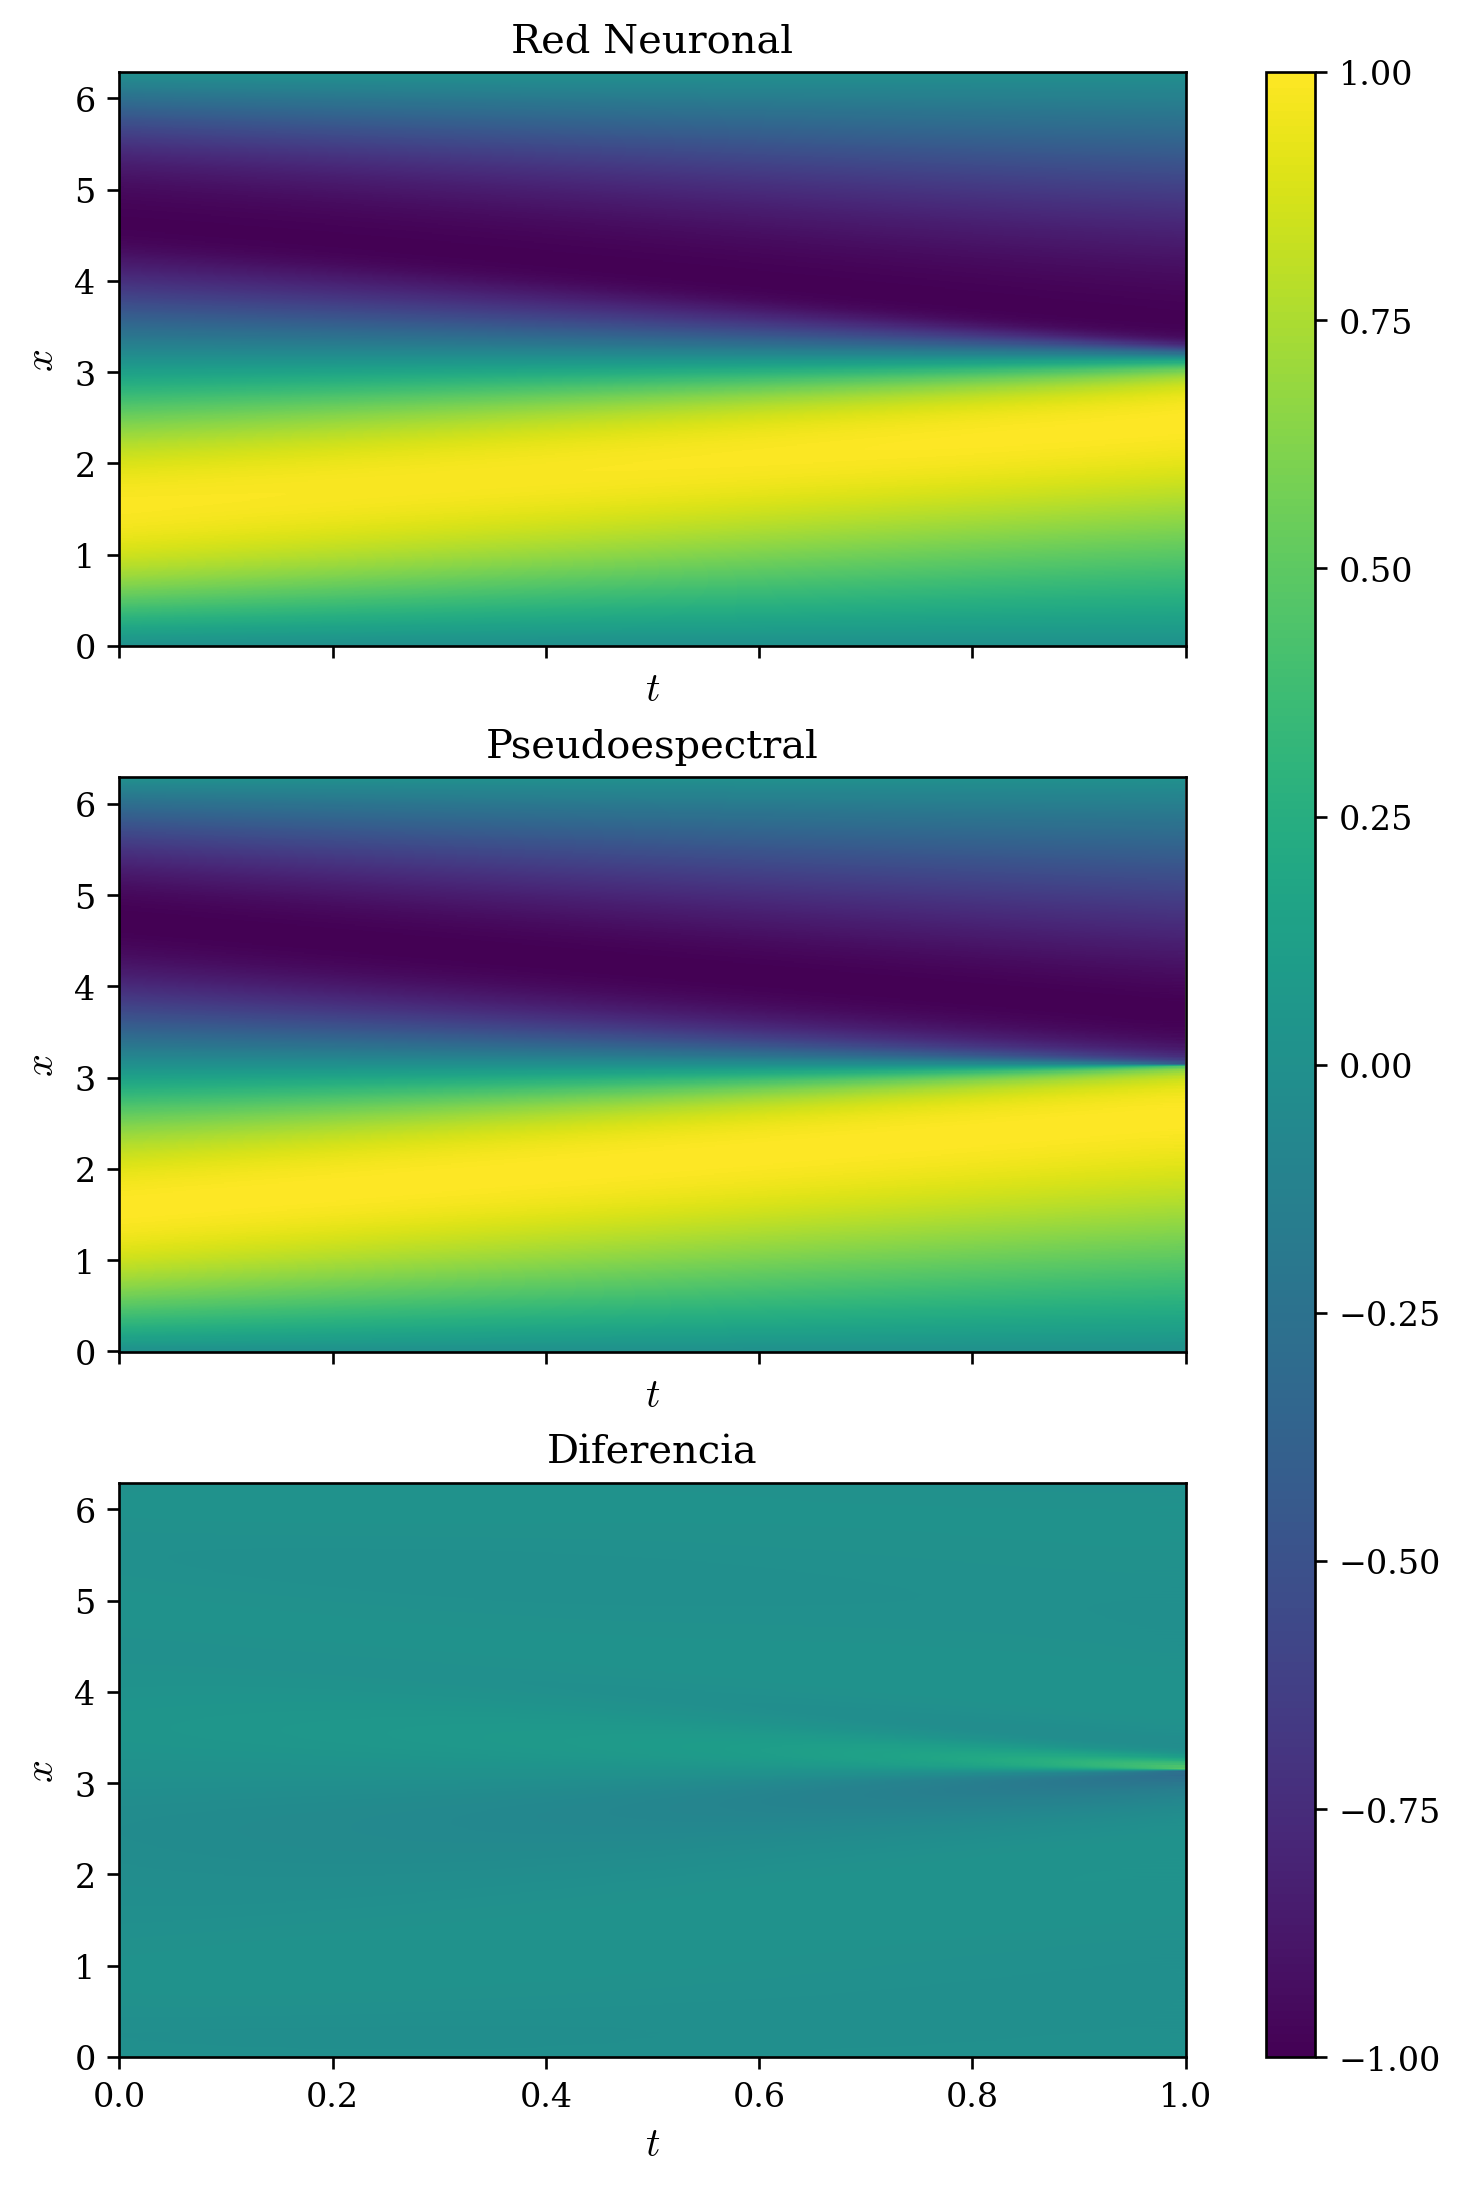

In [95]:
# Cargo la red de 12 capas de 30 neuronas:
model_name = "burgers_solver_tanh_08"
model_info_dict = get_model_info(model_name)
pinn = CustomFunctionMLP(sizes=model_info_dict["layers"], activation=torch.tanh)
pinn.load_state_dict(torch.load(f"modelos_entrenados/{model_name}.pth"))
# Para graficar la Red Neuronal
t_plot = torch.linspace(0, 1, 1000)  # Definimos muestra temporal para graficar
x_plot = torch.linspace(0, 2 * np.pi, 512)  # Definimos muestra espacial para graficar
xx_plot, tt_plot = np.meshgrid(x_plot, t_plot, indexing='ij')
xx_plot = xx_plot[:, :, None]  # Agregamos una dimensión al final para que pueda ser input de la red
tt_plot = tt_plot[:, :, None]  # Agregamos una dimensión al final para que pueda ser input de la red
input_plot = np.concatenate([xx_plot, tt_plot], axis=-1)
u_plot = pinn(torch.tensor(input_plot))  # Evaluamos la red en la grilla
u_plot = u_plot.detach().numpy().reshape(512, 1000)
xx_plot = xx_plot.reshape(512, 1000)
tt_plot = tt_plot.reshape(512, 1000)
# Para graficar la solución de pseudoespectral
# (habiendo corrido la celda correspondiente en el punto 3.a)
xx_vals, tt_vals = np.meshgrid(x_vals, t_vals[:1000], indexing='ij')
plt.close("all")
%matplotlib inline
fig, axs = plt.subplots(3, 1, figsize=(6, 9), constrained_layout=True, sharex=True, sharey=True)
axs[0].pcolormesh(
    tt_plot.T, xx_plot.T, u_plot.T,
    cmap="viridis", vmin=-1, vmax=1
)
axs[0].set_title("Red Neuronal")
axs[1].pcolormesh(
    tt_vals.T, xx_vals.T, u[:, :1000].T,
    cmap="viridis", vmin=-1, vmax=1
)
axs[1].set_title("Pseudoespectral")
cmap = axs[2].pcolormesh(
    tt_plot.T, xx_plot.T, u_plot.T - u[:, :1000].T,
    cmap="viridis", vmin=-1, vmax=1
)
axs[2].set_title("Diferencia")
plt.colorbar(cmap, ax=axs, aspect=40)
for ax in axs:
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$x$")
plt.show()

Arriba se grafica la solución en el intervalo $t \in [-0, 1]$ calculada con la red de 12 capas ocultas de 30 neuronas cada una, el método pseudoespectral y la diferencia entre ambos arreglos. En la última figura puede notarse que ambos metodos difieren sobretodo en la región de la discontinuidad, donde o bien la red no logra capturar la discontinuidad de la derivada de la solución o bien comienzan a aparecer fenómenos de Gibbs en el método pseudoespectral.

## b)
Para ahorrar pasos de entrenamiento, voy a continuar con el entrenamiento de la red de 12 capas de 30 neuronas a partir de la solución obtenida en el punto anterior la cual ya aprendió en gran medida la condición inicial y la condición de contorno:

In [98]:
# Cargo la red de 12 capas de 30 neuronas:
model_name = "burgers_solver_tanh_08"
model_info_dict = get_model_info(model_name)
pinn = CustomFunctionMLP(sizes=model_info_dict["layers"], activation=torch.tanh)
pinn.load_state_dict(torch.load(f"modelos_entrenados/{model_name}.pth"))
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)

epochs = 2_000
nu = 1e-2  # A diferencia del punto anterior
pesos_perdida = (1, 1, 1)
loss_vals = train_burgers_solver(
    pinn,
    optimizer,
    iterations=epochs, # Numero de iteraciones
    initial_conditions_inputs=input_init,
    initial_conditions_labels=y_data_init,
    boundary_conditions_inputs=input_cc,
    boundary_conditions_labels=y_data_cc,
    physics_inputs=input_physics,
    loss_weights=pesos_perdida,  # Peso para cada error
    nu=nu,  # Viscosidad de la ecuación de Burgers
)

 2000 CI MSE:  0.0001375    CC MSE:  5.213e-07    Phys MSE:  0.0004696    Traning Loss:  0.0006076


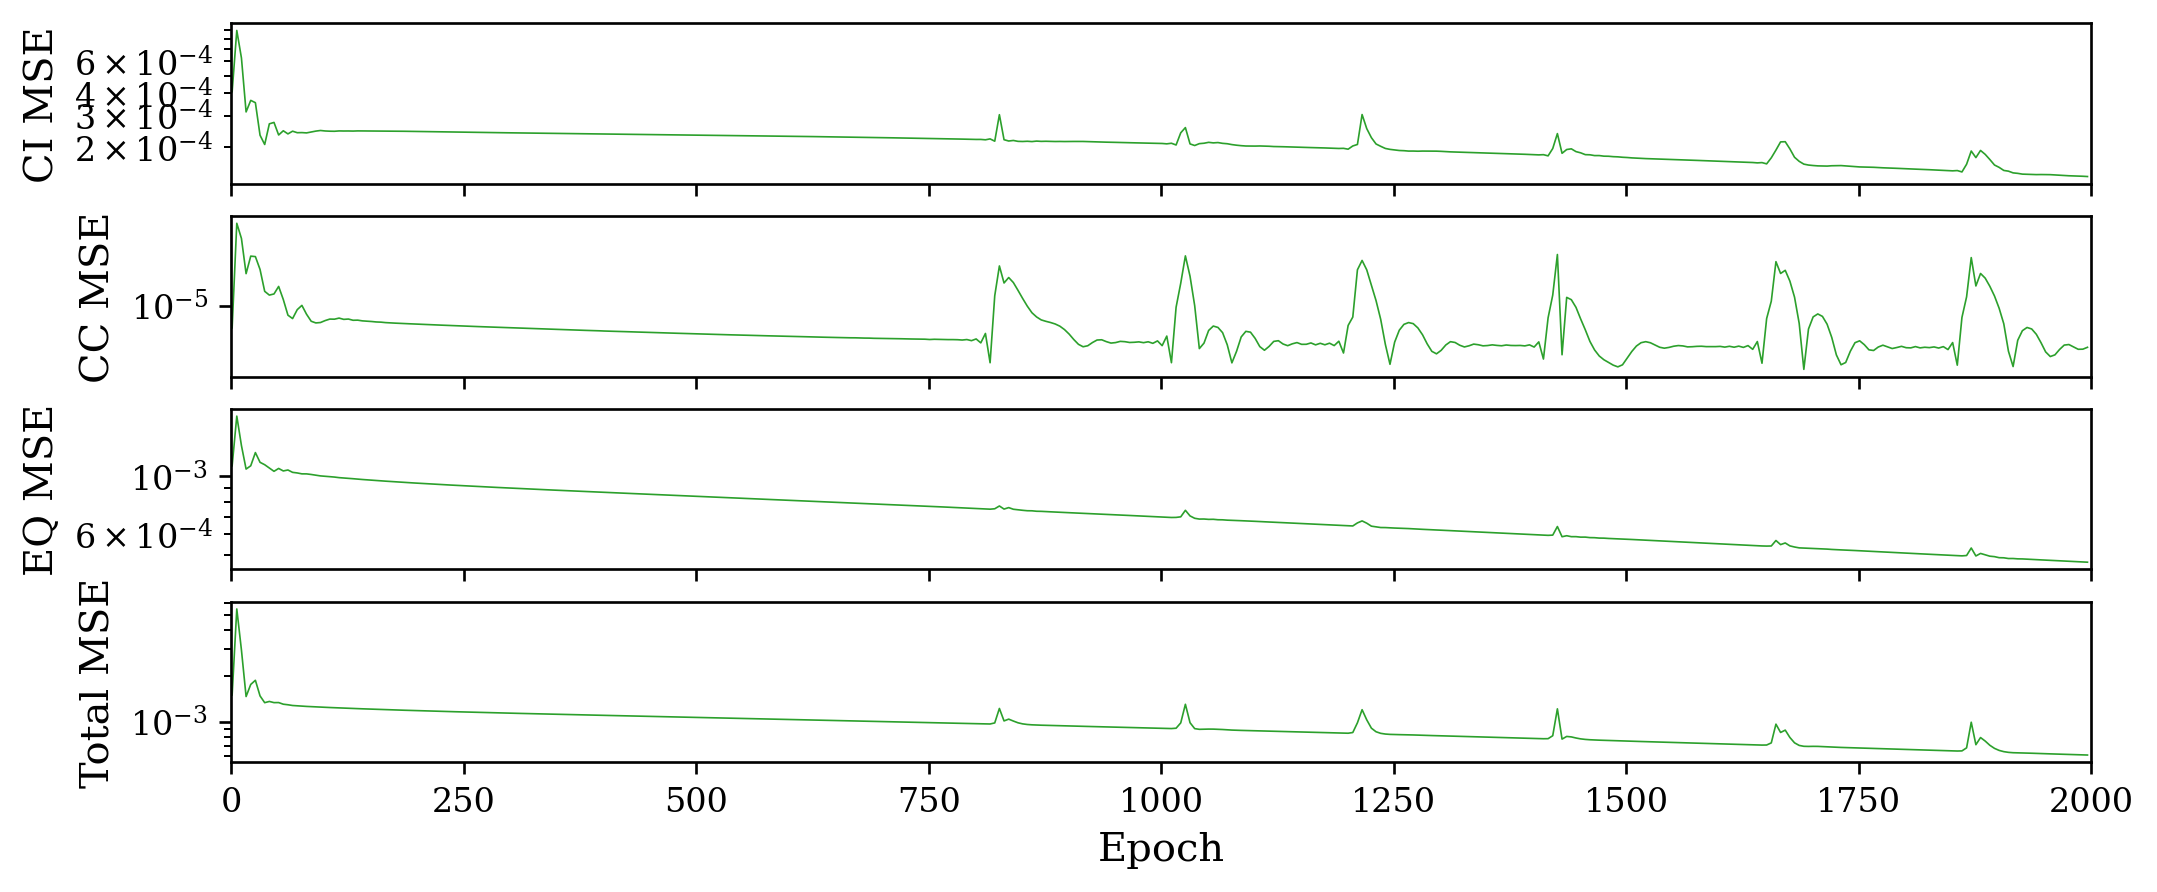

In [99]:

plot_training_loss(
    loss_vals,
    plot_every=5,
    ms=None, lw=0.5,
    **get_model_style(model_name),
    label=tags[model_name],
)
# Extended legend over first ax:
# for ax, y_lim in zip(axs, plot_extremes):
#     ax.set_ylim(y_lim[0]*0.2, y_lim[1]*5)
plt.show()

Aquí puede notarse que aprovechando lo aprendido en el entrenamiento anterior se alcanzan en tan solo 2000 iteraciones niveles de perdida comparables a o mejores que los que se alcanzaban en 5000 iteraciones en el punto anterior.

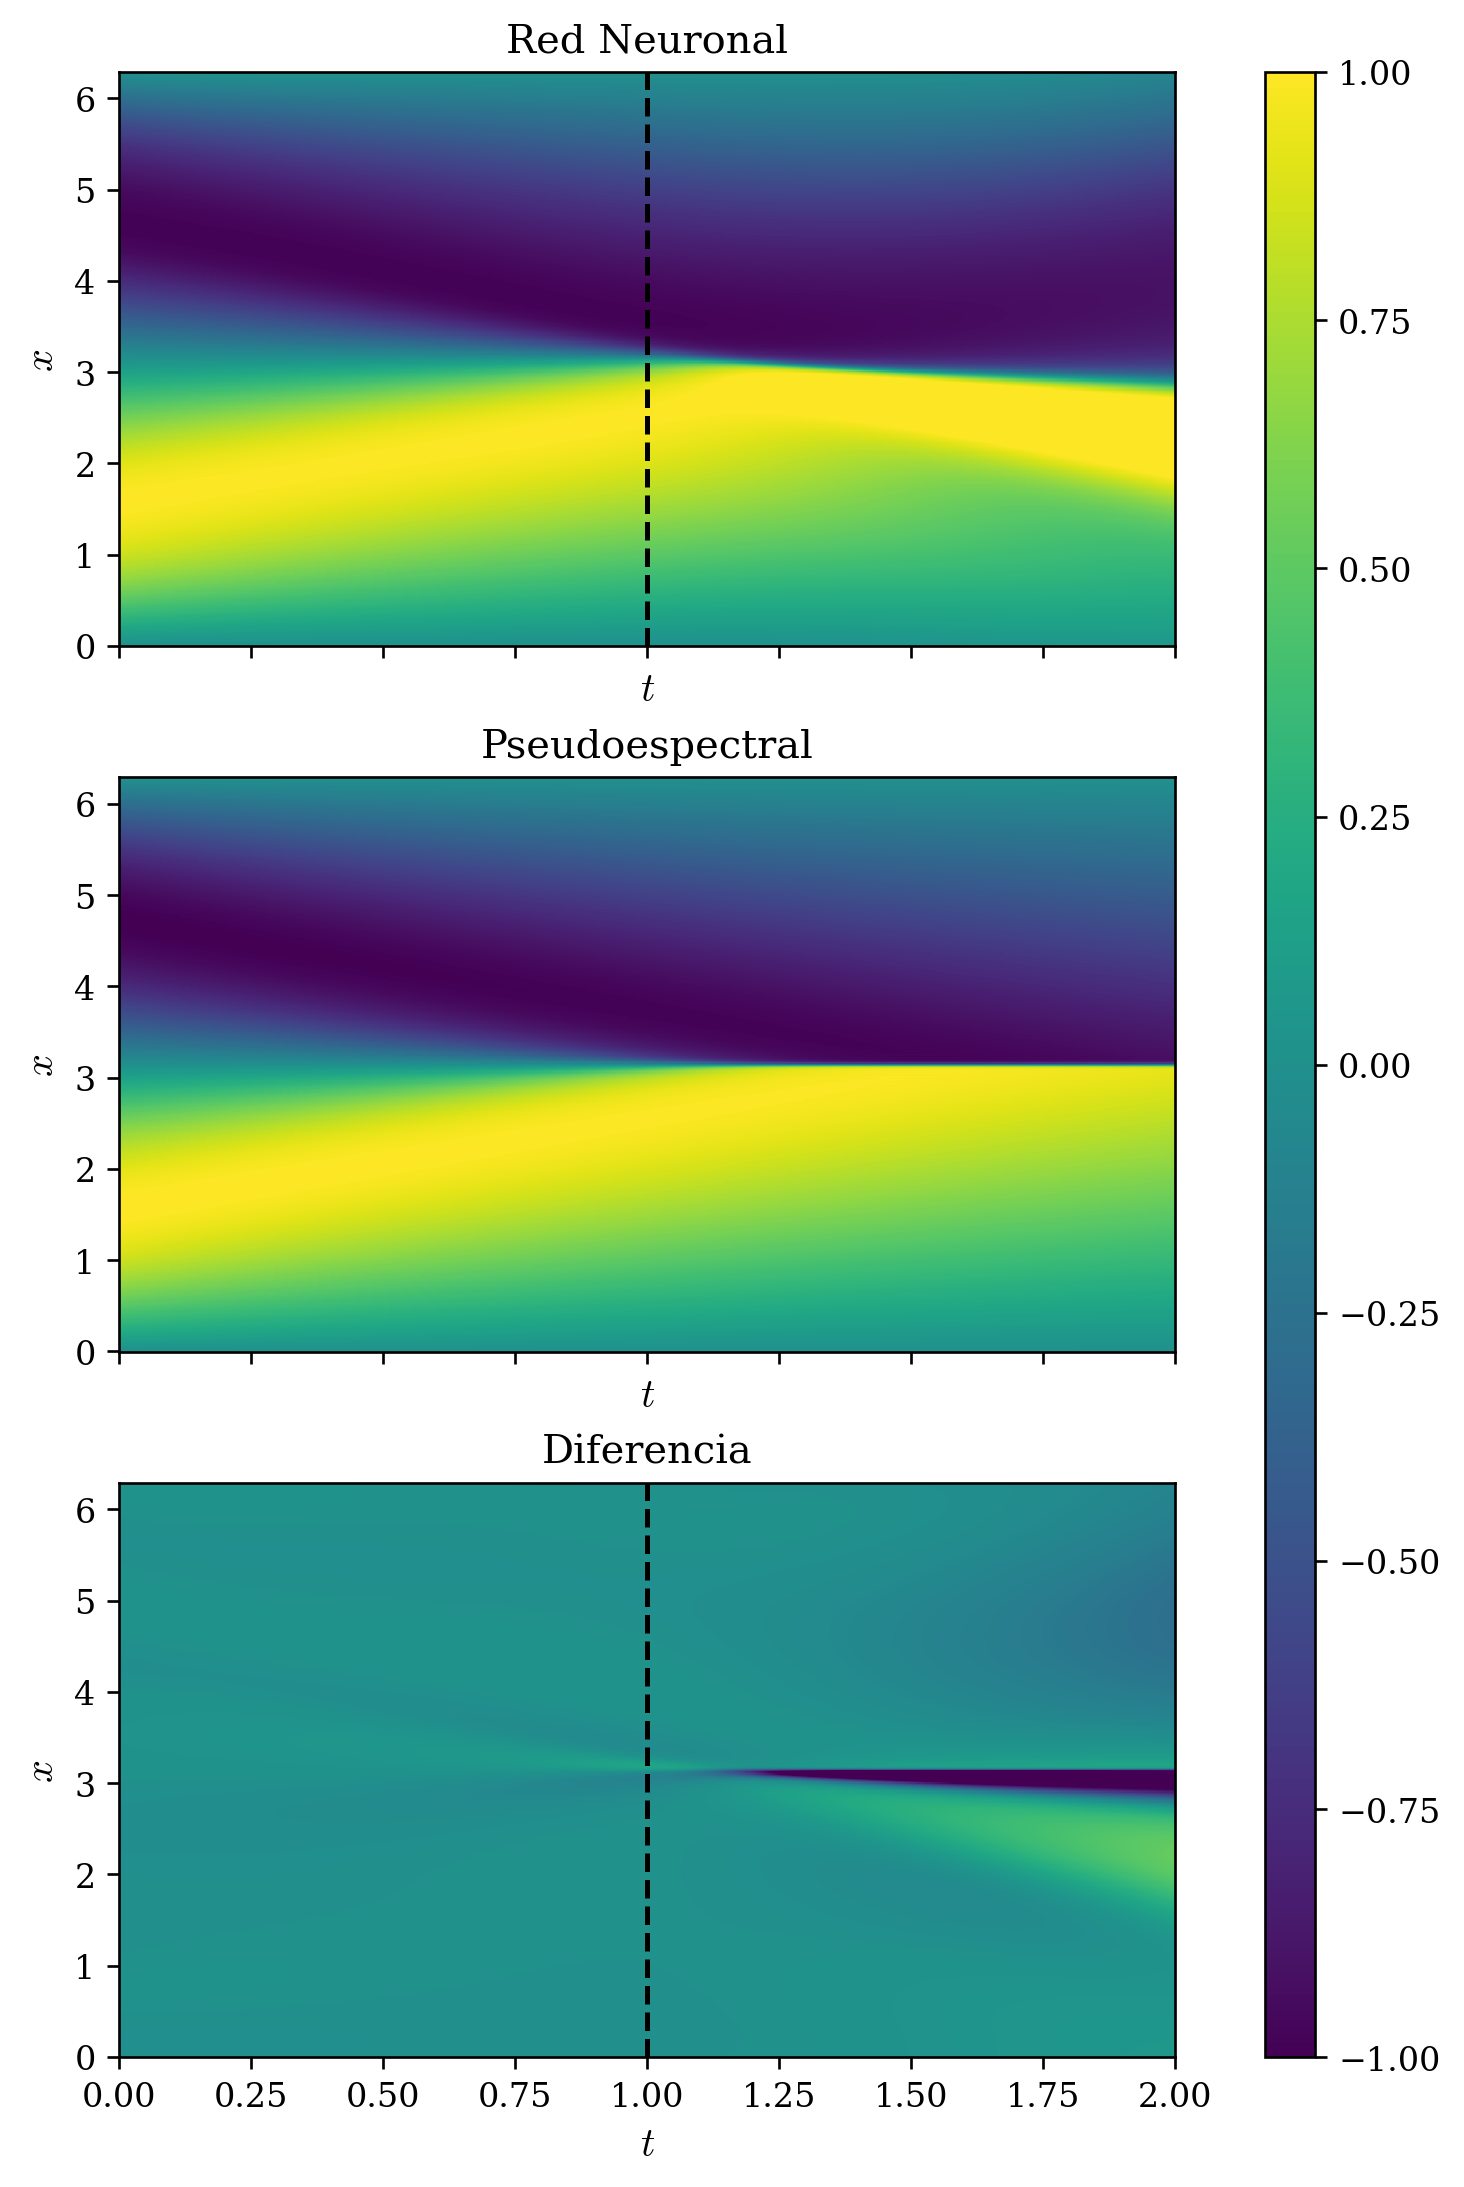

In [108]:
# Para graficar la Red Neuronal
t_plot = torch.linspace(0, 2, 2000)  # Definimos muestra temporal para graficar
x_plot = torch.linspace(0, 2 * np.pi, 512)  # Definimos muestra espacial para graficar
xx_plot, tt_plot = np.meshgrid(x_plot, t_plot, indexing='ij')
xx_plot = xx_plot[:, :, None]  # Agregamos una dimensión al final para que pueda ser input de la red
tt_plot = tt_plot[:, :, None]  # Agregamos una dimensión al final para que pueda ser input de la red
input_plot = np.concatenate([xx_plot, tt_plot], axis=-1)
u_plot = pinn(torch.tensor(input_plot))  # Evaluamos la red en la grilla
u_plot = u_plot.detach().numpy().reshape(512, 2000)
xx_plot = xx_plot.reshape(512, 2000)
tt_plot = tt_plot.reshape(512, 2000)
# Para graficar la solución de pseudoespectral
# (habiendo corrido la celda correspondiente en el punto 3.a)
xx_vals, tt_vals = np.meshgrid(x_vals, t_vals[:2000], indexing='ij')
plt.close("all")
%matplotlib inline
fig, axs = plt.subplots(3, 1, figsize=(6, 9), constrained_layout=True, sharex=True, sharey=True)
axs[0].pcolormesh(
    tt_plot.T, xx_plot.T, u_plot.T,
    cmap="viridis", vmin=-1, vmax=1
)
axs[0].axvline(1, c="k", ls="--")
axs[0].set_title("Red Neuronal")
axs[1].pcolormesh(
    tt_vals.T, xx_vals.T, u[:, :2000].T,
    cmap="viridis", vmin=-1, vmax=1
)
axs[1].set_title("Pseudoespectral")
cmap = axs[2].pcolormesh(
    tt_plot.T, xx_plot.T, u_plot.T - u[:, :2000].T,
    cmap="viridis", vmin=-1, vmax=1
)
axs[2].axvline(1, c="k", ls="--")
axs[2].set_title("Diferencia")
plt.colorbar(cmap, ax=axs, aspect=40)
for ax in axs:
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$x$")
plt.show()

Graficando ahora ambas soluciones en el intervalo $t \in [0, 2]$ se observa que, como era de esperarse, la Red Neuronal no extrapola correctamente la solución y comienza a diverger de la solución pseudo-espectral. Dicho esto, en el intervalo $t \in [0, 1]$ la solución de la red neuronal es bastante similar a la solución pseudo-espectral.

No me dió el tiempo para seguir desarrollando pero me interesó mucho el ejercicio. Originalmente tenía la idea de explorar diferentes funciones de activación y pesos relativos en el entrenamiento pero solo llegue a explorar (y de manera limitada) la configuración de las capas ocultas.

También me hubiera interesado realizar este último análisis de $\nu = 10^{-2}$ entrenando a la red en el intervalo $t \in [0, 2]$ para ver si la red neuronal logra capturar la discontinuidad de la derivada de la solución en $t > 1$, pero nuevamente, no me organicé bien.

## **Ejercicio 5: Ecuación de Kardar-Parisi-Zhang** (Burgers potencial)

La ecuación de Burgers en forma potencial puede hallarse considerando $\overline{u} = \overline{\nabla}\phi$:

\begin{equation*}
    \frac{\partial \phi}{\partial t} + \frac{1}{2}\left(\overline{\nabla}\phi\right)^2 - \nu \nabla^2 \phi.
\end{equation*}

A partir de esto, el modelo de Kardar-Parisi-Zhang (KPZ) se obtiene mediante un cambio de variables simple para $\phi(x,t)$ y agregando difusión y ruido al azar:

\begin{equation*}
    \frac{\partial h}{\partial t} + \frac{\lambda^2}{2}\left(\overline{\nabla}h\right)^2 - \nu \nabla^2 h + \eta,
\end{equation*}

donde $\eta$ representa un ruido Gaussiano.

Dada la versión lineal de KPZ (Burgers potencial) con forzado aleatorio

\begin{equation*}
    \frac{\partial \phi}{\partial t} +  \frac{1}{2}\left(\frac{\partial \phi}{\partial x}\right)^2-\nu \frac{\partial^2 \phi}{\partial x^2}+\eta
\end{equation*}

donde $\eta(x,t)$ es ruido aleatorio con valor medio nulo, se pide:

$\bf a).$ Integrá la ecuación con condiciones de contorno periódicas entre $x \in [0,2\pi)$, partiendo de una velocidad inicial nula y un ruido aleatorio con valor medio nulo. Como integrador temporal puede usarse Runge Kutta de orden 2.


$\bf b).$ Graficá la evolución en $(x,t)$, la evolcuión  para distintos t ($u(x,t)$ vs $t$) y zoom sucesivos para el ultimo tiempo. Describí cualitativamente la dinámica.

$\bf c)$ Cómo recupero Burgers? Graficá al menos una solución (alcanza con una condición inicial y una evolución de la misma para un tiempo) que sea como las que obtuviste en los ejercicios anteriores. Explicá (o escribí explicitamente en tu implementacion numérica) de que forma obtuviste esta solución.







## **Bloques para la integración temporal**

Pueden completar el siguiente bloque para la integración temporal.
Tengan en cuenta que pueden reciclar bastante del ejercicio anterior

In [109]:
def evol(phi: ArrayLike, k: ArrayLike, nu: float, N: float, dt: float):
    """Evoluciona en el tiempo la PDE usando el método pseudoespectral y \
Runge-Kutta de segundo orden.
    """
    phi_hat = np.fft.rfft(phi)  # Transformamos al espacio de Fourier
    phi_hat_inicial = phi_hat  # Guardamos el estado inicial
    eta = compute_random(N)  # Calculamos el ruido para cada iteración completa de Runge-Kutta
    for ord in [2,1]:  # Bucle para el Runge-Kutta
        D = dt/ord
        phix_hat = 1j*k*phi_hat  # d(phi)/dx en el espacio fourier
        phix2_hat = compute_vv(phix_hat, N)  # (d(phi)/dx)² en el espacio fourier
        phixx_hat = -k**2*phi_hat  # d²(phi)/dx² en el espacio fourier
        phi_hat = phi_hat_inicial + D * (nu * phixx_hat - phix2_hat/2 - eta)  # Integramos en el tiempo
        phi_hat[int(N/3):] = 0  # Dealiasing
    out = np.fft.irfft(phi_hat)  # Transformamos al espacio real
    return out

def compute_vv(phix_hat, N):
    """Calcula phix**2 usando el método pseudoespectral y devuelve el resultado \
en el espacio Fourier.
    """
    phix = np.fft.irfft(phix_hat)  # Transformamos al espacio real
    phix2_hat = np.fft.rfft(phix**2)  # Transformamos al espacio de Fourier
    return phix2_hat

def compute_random(N):
    # Genera ruido Gaussiano con media nula y varianza unitaria en el espacio Fourier
    fase = 2*np.pi*np.random.rand(int(N/2+1))  # Fase aleatoria en [0,2*pi]
    amplitud = np.random.randn(int(N/2+1))  # Amplitud aleatoria con distribución normal
    out = amplitud*np.exp(1j*fase)  # Números complejos con distribución normal
    out[0] = 0.  # Llevo la frecuencia cero a amplitud nula
    return out

In [110]:
# Defino mis puntos en el espacio real y los modos para el espacio de Fourier
nx = 512
tf = 1
dt = 1e-3
L = 2 * np.pi

x_vals = np.linspace(0, L, nx, endpoint=True)  # Coordenada espacial en [0,2*pi]
t_vals = np.arange(0, tf + dt/2, dt)  # Tiempo
nt = t_vals.size
# Números de onda ordenados como en la FFT
k_vals = np.fft.rfftfreq(nx, d=(x_vals[1] - x_vals[0])) * 2 * np.pi

In [111]:
nu = 1e-2
phi = np.empty([nx, nt])  # Array con el potencial
# phi[:, 0] = np.sin(2*np.pi*x_vals/L)  # CI: senoidal pura
# phi[:, 0] = np.sin(x_vals) + np.sin(20*x_vals)/20 - np.cos(x_vals)  # CI: suma de armónicas
# phi[:, 0] = np.exp(- (x_vals - L/2)**2 / 0.5**2)  # CI: gaussiana
phi[:, 0] = 0  # CI: constantemente cero

# Aplico el método de Euler para la integración temporal
for n in range(nt - 1):
    phi[:, n+1] = evol(phi[:, n], k_vals, nu, nx, dt)

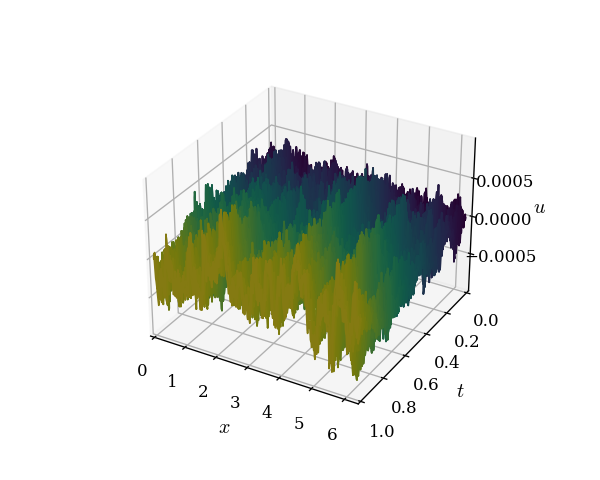

In [112]:
%matplotlib widget
fig, ax, v_cmap = plot_3d_evolution(x_vals, t_vals, phi, cmap_name="viridis")
fig.set_label("Evolución de la Ecuación de Burgers mediante Método Pseudoespectral")
# fig.suptitle(r"$u(x, 0) = \cos(x) + \cos(2x) + sin(x)$")
plt.show()

Esto también me quedó sin hacer, aunque llegué a discutir algunas de las soluciones y desafios con compañeros. En cualquier caso veré de avanzar y terminarlo entre guías.